# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as cls
%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import MultiLabelBinarizer 
from collections import Counter
from wordcloud import WordCloud
from PIL import Image
import random
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# Data Familiarization

In [3]:
# Uploading dataset
df = pd.read_csv('netflix_titles.csv')
df.head(4)

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [5]:
print('-'*40)
print('\033[1m', 'Shape of the dataset: {}'. format(df.shape), '\033[0m')
print('-'*40)

----------------------------------------
 Shape of the dataset: (8807, 12) 
----------------------------------------


In [6]:
# Columns with most unique features
df.nunique().sort_values(ascending=False)

title           8807
show_id         8807
description     8775
cast            7692
director        4528
date_added      1767
country          748
listed_in        514
duration         220
release_year      74
rating            17
type               2
dtype: int64

# Missing Data

In [7]:
na_list = []
for i in df.columns:
    na = df[i].isnull().sum()
    if na != 0 :
        na_list.append([i, na])
        
na_df = pd.DataFrame(na_list, columns = ['Columns', 'Null'])
na_df.set_index('Columns')

# Total number of Null values in each columns:
print('\033[1m', na_df, '\033[0m')

       Columns  Null
0    director  2634
1        cast   825
2     country   831
3  date_added    10
4      rating     4
5    duration     3 


In [8]:
# Total % of null values in columns
x = np.round(na_df['Null'] * 100 / (len(df)),3)
index = na_df['Columns']
print('-'*40)
for i in na_df.index:
    print('\033[1m', index[i], '->', x[i], '% missing values', '\033[0m')
    print('-'*40)

----------------------------------------
 director -> 29.908 % missing values 
----------------------------------------
 cast -> 9.368 % missing values 
----------------------------------------
 country -> 9.436 % missing values 
----------------------------------------
 date_added -> 0.114 % missing values 
----------------------------------------
 rating -> 0.045 % missing values 
----------------------------------------
 duration -> 0.034 % missing values 
----------------------------------------


----------------------------------------
 Total columns with Null Values: 
 6 
----------------------------------------
 Total Null Values: 
 4307 
----------------------------------------


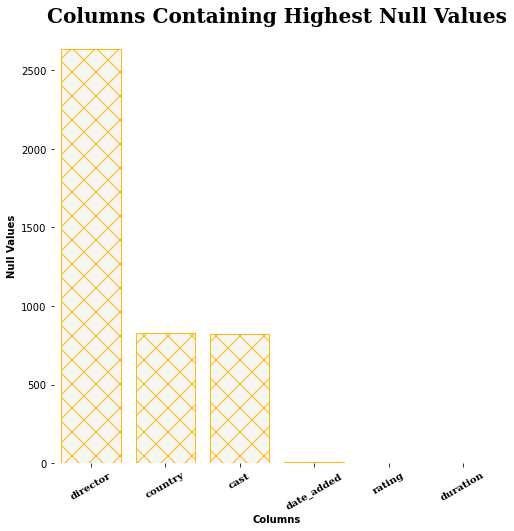

In [9]:
# Summarizing and Visualizing Null Values
print('-'*40)
print('\033[1m', 'Total columns with Null Values:', '\033[0m')
print('\033[1m', len(na_df), '\033[0m')
print('-'*40)
print('\033[1m', 'Total Null Values:', '\033[0m')
print('\033[1m', na_df['Null'].sum(axis = 0), '\033[0m')
print('-'*40)
plt.figure(figsize = (8,8))
sns.barplot(data = na_df.sort_values(by ='Null', ascending=False), x = 'Columns', y = 'Null', color = '#f5f5f1',
            edgecolor ='#FFB90F', hatch = '\/')
plt.ylabel('Null Values', fontweight = 'bold')
plt.xlabel('Columns', fontweight = 'bold')
plt.box(on=None)
plt.title('Columns Containing Highest Null Values', fontsize=20, fontweight='bold', fontfamily='serif')
plt.xticks(fontweight='bold', fontfamily='serif', rotation = 30)
plt.show()

## Imputing Missing Values:

* **Country**: We will be filling NaN values with the help of the director column and where both are NaN we will be filling mode values.

In [10]:
df['country'] = df['country'].replace('', np.nan).fillna(df.groupby('director')['country'].transform('first'))

In [11]:
df['country'].isna().sum()

683

In [12]:
df['country'].fillna(value = df['country'].mode()[0], inplace = True)

* **Director**: We will not drop this column for analysis, despite having 30% of null values. Instead, we will fill **'No Director Specified'**  with null values.

In [13]:
df['director'].fillna(value = 'No Director Specified', inplace = True)

* **Cast**: Similar to director column, we will fill **'No Cast Specified'** with null values.

In [14]:
df['cast'].fillna(value = 'No Cast Specified', inplace = True)

* **Date-Added**: Since this column shows the date on which the movie/tv series is added to the platform and not the actual release date. Therefore we will be filling NaN values with mode.

In [15]:
df['date_added'].fillna(value = df['date_added'].mode()[0], inplace = True)

* **Rating & Duration**: There are some connections between the columns. We see that the null values in the duration columns are due to a mismatch and the values are accidentally noted in the rating column. The type column will allow us to fill in the null values in the rating column. 

In [16]:
df['rating'].value_counts()

TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
66 min         1
74 min         1
84 min         1
Name: rating, dtype: int64

In [17]:
df[df['duration'].isnull()]

show_id   type                                 title    director  \
5541   s5542  Movie                       Louis C.K. 2017  Louis C.K.   
5794   s5795  Movie                 Louis C.K.: Hilarious  Louis C.K.   
5813   s5814  Movie  Louis C.K.: Live at the Comedy Store  Louis C.K.   

            cast        country          date_added  release_year  rating  \
5541  Louis C.K.  United States       April 4, 2017          2017  74 min   
5794  Louis C.K.  United States  September 16, 2016          2010  84 min   
5813  Louis C.K.  United States     August 15, 2016          2015  66 min   

     duration listed_in                                        description  
5541      NaN    Movies  Louis C.K. muses on religion, eternal love, gi...  
5794      NaN    Movies  Emmy-winning comedy writer Louis C.K. brings h...  
5813      NaN    Movies  The comic puts his trademark hilarious/thought...

In [18]:
df['duration'] = np.where((df.duration.isnull() == True ), df['rating'], df['duration'])

In [19]:
df.loc[[5541,5794,5813]]

show_id   type                                 title    director  \
5541   s5542  Movie                       Louis C.K. 2017  Louis C.K.   
5794   s5795  Movie                 Louis C.K.: Hilarious  Louis C.K.   
5813   s5814  Movie  Louis C.K.: Live at the Comedy Store  Louis C.K.   

            cast        country          date_added  release_year  rating  \
5541  Louis C.K.  United States       April 4, 2017          2017  74 min   
5794  Louis C.K.  United States  September 16, 2016          2010  84 min   
5813  Louis C.K.  United States     August 15, 2016          2015  66 min   

     duration listed_in                                        description  
5541   74 min    Movies  Louis C.K. muses on religion, eternal love, gi...  
5794   84 min    Movies  Emmy-winning comedy writer Louis C.K. brings h...  
5813   66 min    Movies  The comic puts his trademark hilarious/thought...

In [20]:
# Sepreating the database by the type of the content.
tv_shows = df[df['type'] == 'TV Show']
movies = df[df['type']=='Movie']

In [21]:
tv_shows['rating'].fillna(value = tv_shows['rating'].mode()[0], inplace = True)

In [22]:
movies['rating'].fillna(value = movies['rating'].mode()[0], inplace = True)
# Correcting the wrong inputed data
movies['rating'] = np.where((movies.rating == '74 min'), movies['rating'].mode()[0], movies['rating'])
movies['rating'] = np.where((movies.rating == '66 min'), movies['rating'].mode()[0], movies['rating'])
movies['rating'] = np.where((movies.rating == '84 min'), movies['rating'].mode()[0], movies['rating'])

In [23]:
df.update(tv_shows)
df.update(movies)

In [24]:
# Checking for any more missing values
na_features = []
for f in df.columns:
    if df[f].isnull().sum()>0:
        na_features.append(f)

# Printing with different colours:
# PURPLE = '\033[95m', CYAN = '\033[96m', DARKCYAN = '\033[36m', BLUE = '\033[94m', GREEN = '\033[92m', YELLOW = '\033[93m'
# RED = '\033[91m', BOLD = '\033[1m', UNDERLINE = '\033[4m', END = '\033[0m'
if not na_features:
    print('\033[91m'+'\033[1m'+ '\nNo Missing Values found\n' + '\033[0m')
else:

    print('\033[91m'+'\033[1m'+ '\nMissing Values found\n' + '\033[0m')


No Missing Values found



In [25]:
# final df without missing values
df.head(4)

show_id     type                  title               director  \
0      s1    Movie   Dick Johnson Is Dead        Kirsten Johnson   
1      s2  TV Show          Blood & Water  No Director Specified   
2      s3  TV Show              Ganglands        Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans  No Director Specified   

                                                cast        country  \
0                                  No Cast Specified  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...         France   
3                                  No Cast Specified  United States   

           date_added  release_year rating   duration  \
0  September 25, 2021        2020.0  PG-13     90 min   
1  September 24, 2021        2021.0  TV-MA  2 Seasons   
2  September 24, 2021        2021.0  TV-MA   1 Season   
3  September 24, 2021        2021.0  TV-MA   1 Season   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...

# Feature Creation & Transformation (Feature Engineering)

In [26]:
## Featuring Engineering on 'date_added'
# Creating new columns 'month_added' and 'year_added'
df['month_added'] = df['date_added'].apply(lambda x : x.split(" ")[0])
df['month_added'] = np.where((df.month_added == ''), df['date_added'].apply(lambda x : x.split(" ")[1]), df['month_added'])
df['year_added'] = df['date_added'].apply(lambda x : x.split(" ")[-1])

In [27]:
# We can see multiple countries for some titles. Therefore we will be creating a new column with a primary country.
df['primary_country'] = df['country'].apply(lambda x : x.split(',')[0])

In [28]:
# Removing unwanted information from duration column
df['duration'] = df['duration'].apply(lambda x : x.split(' ')[0])

In [29]:
# Creating a new column 'target_ages' from 'rating'
ratings_ages = {'TV-PG': 'Older Kids', 'TV-MA': 'Adults', 'TV-Y7-FV': 'Older Kids', 'TV-Y7': 'Older Kids', 'TV-14': 'Teens',
                'R': 'Adults', 'TV-Y': 'Kids', 'NR': 'Adults', 'PG-13': 'Teens', 'TV-G': 'Kids', 'PG': 'Older Kids', 
                'G': 'Kids', 'UR': 'Adults', 'NC-17': 'Adults'}

df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

array(['Teens', 'Adults', 'Older Kids', 'Kids'], dtype=object)

In [30]:
# Ordinal Scaling of months 
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November',
               'December']

df['month_added'] = pd.Categorical(df['month_added'], categories=month_order, ordered=True)

In [31]:
# Transforming the data types from str to int
df['release_year'] = df['release_year'].astype(int)
df['year_added'] = df['year_added'].astype(int)
df['duration'] = df['duration'].astype(int)

In [32]:
# Changing column name of 'listed_in' to 'Genre'
df = df.rename(columns = {"listed_in":"genre"})

In [33]:
# Creating a copy of the dataframe and filling empty cells of the 'director' and 'cast' columns for recommendation system
rec = df.copy()
rec['director'].replace(' ', 'Director Not Specified', inplace = True)
rec['cast'].replace(' ', 'Cast Not Specified', inplace = True)

In [34]:
# Seprating each genre of each row
df['genre'] = df['genre'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))

In [35]:
# final df after feature creation and transformation
df.head(4)

show_id     type                  title               director  \
0      s1    Movie   Dick Johnson Is Dead        Kirsten Johnson   
1      s2  TV Show          Blood & Water  No Director Specified   
2      s3  TV Show              Ganglands        Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans  No Director Specified   

                                                cast        country  \
0                                  No Cast Specified  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...         France   
3                                  No Cast Specified  United States   

           date_added  release_year rating  duration  \
0  September 25, 2021          2020  PG-13        90   
1  September 24, 2021          2021  TV-MA         2   
2  September 24, 2021          2021  TV-MA         1   
3  September 24, 2021          2021  TV-MA         1   

                                               genre  \
0                                    [Documentaries]   
1  [International TV Shows, TV Dramas, TV Mysteries]   
2  [Crime TV Shows, International TV Shows, TV Ac...   
3                           [Docuseries, Reality TV]   

                                         description month_added  year_added  \
0  As her father nears the end of his life, filmm...   September        2021   
1  After crossing paths at a party, a Cape Town t...   September        2021   
2  To protect his family from a powerful drug lor...   September        2021   
3  Feuds, flirtations and toilet talk go down amo...   September        2021   

  primary_country target_ages  
0   United States       Teens  
1    South Africa      Adults  
2          France      Adults  
3   United States      Adults

# Exploratory Data Analysis (Data Visualization)

In this section we will be exploring our dataset to find out meaningful insights and visualize it for better understanding.

In [36]:
# Temporary column for count
df['count'] = 1

# Splitting dataset based on type
tv = df[df["type"] == "TV Show"]
movies = df[df["type"] == "Movie"]

## Content

Netflix is a streaming service that offers a wide variety of award-winning TV shows, movies, anime, documentaries, and more on thousands of internet-connected devices. There's always something new to discover and new TV shows and movies are added every week!. Let's have a look at the content they offer...

In [37]:
# Ratio of Movies & TV shows
x=df['type'].value_counts()
r=(x/len(df)).round(2)
t_ratio = pd.DataFrame(r).T

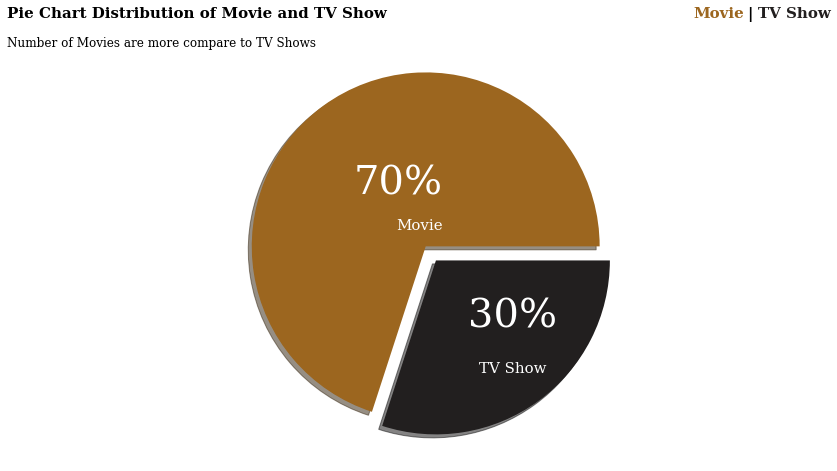

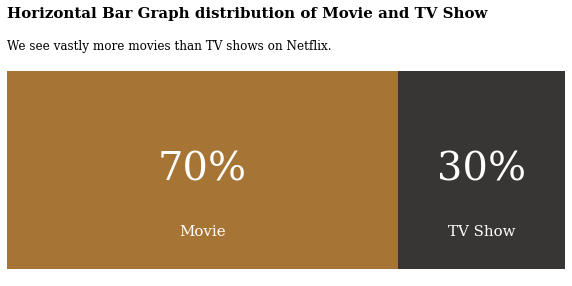

In [38]:
## Pie plot
fig, ax = plt.subplots(1,1,figsize=(15, 8))
ax.pie(r, explode = [0.0,0.1], colors=['#9C661F', '#221f1f'], shadow = True)


# Plotting Values
ax.annotate(f"{int(0.7*100)}%", xy=(.1, 0.3), ha='right',fontsize=40, fontweight='light', fontfamily='serif', color='white')

ax.annotate("Movie", xy=(0.1, 0.1), ha='right',fontsize=15, fontweight='light', fontfamily='serif', color='white')
    
ax.annotate(f"{int(0.3*100)}%", xy=(1/2, -0.4), va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
            color='white')
    
ax.annotate("TV Show", xy=(1/2, -0.70), va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
            color='white')


# Title
fig.text(0.125,0.90,'Pie Chart Distribution of Movie and TV Show', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.85,'Number of Movies are more compare to TV Shows',fontfamily='serif',fontsize=12)  
fig.text(0.76,0.9,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#9C661F')
fig.text(0.81,0.9,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.82,0.9,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_visible(False)

    
# Horizontal Bar Graph
fig1, ax1 = plt.subplots(1,1,figsize=(10, 4))

ax1.barh(t_ratio.index, t_ratio['Movie'], color='#9C661F', alpha=0.9)
ax1.barh(t_ratio.index, t_ratio['TV Show'], left=t_ratio['Movie'], color='#221f1f', alpha=0.9)

ax1.set_xlim(0, 1)
ax1.set_xticks([])
ax1.set_yticks([])

# movie percentage
for i in t_ratio.index:
    ax1.annotate(f"{int(t_ratio['Movie'][i] * 100)}%", 
                   xy=(t_ratio['Movie'][i] / 2, i),
                   va = 'center', ha = 'center',fontsize = 40, fontweight = 'light', fontfamily = 'serif',
                   color = 'white')

    ax1.annotate("Movie", 
                   xy=(t_ratio['Movie'][i] / 2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')
    
    ax1.annotate(f"{int(t_ratio['TV Show'][i]*100)}%", 
                   xy=(t_ratio['Movie'][i] + t_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
    
    ax1.annotate("TV Show", 
                   xy=(t_ratio['Movie'][i] + t_ratio['TV Show'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')


# Title & Subtitle
fig1.text(0.125,1.03,'Horizontal Bar Graph distribution of Movie and TV Show ', fontfamily='serif',fontsize=15,
         fontweight='bold')
fig1.text(0.125,0.92,'We see vastly more movies than TV shows on Netflix.',fontfamily='serif',fontsize=12)  

# Removing borders from plot
for i in ['top', 'left', 'right', 'bottom']:
    ax1.spines[i].set_visible(False)

plt.show()

We observe that 70% of the content available on the platform is movies. Based on this observation, we may conclude that overall, consumers like to use Netflix more than a movie platform than a tv series platform.

## Countries

So we now know there are a lot more movies than TV shows on Netflix. Let's have a look at the content by country.

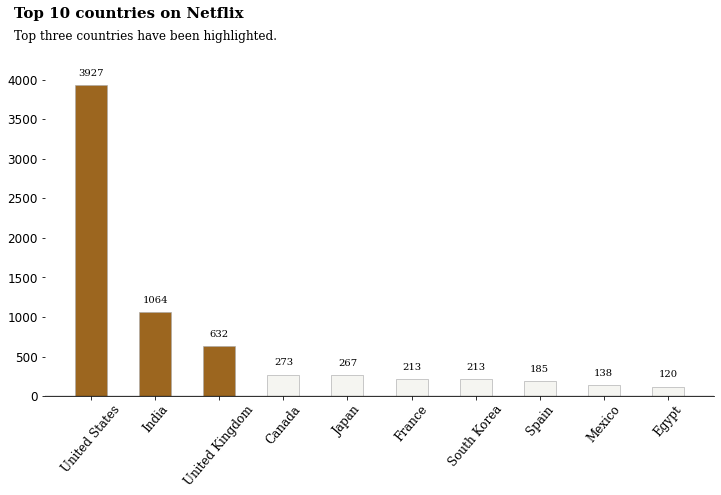

In [39]:
# Top 10 countries
data = df.groupby('primary_country')['count'].sum().sort_values(ascending=False)[:10]

# BarPlot
color_map = ['#f5f5f1' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  '#9C661F' # Top 3 countries color highlight

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(data.index, data, width = 0.5, edgecolor = 'darkgray', linewidth = 0.6, color = color_map)

#annotations
for i in data.index:
    ax.annotate(f"{data[i]}", xy = (i, data[i] + 150), va = 'center', ha = 'center',fontweight = 'light', fontfamily = 'serif')

# Removing borders from plot
for i in ['top', 'left', 'right']:
    ax.spines[i].set_visible(False)
    
# Tick labels
ax.set_xticklabels(data.index, fontfamily='serif', rotation=50)

# Title and Subtitle
fig.text(0.09, 1, 'Top 10 countries on Netflix', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.95, 'Top three countries have been highlighted.', fontsize=12, fontweight='light', fontfamily='serif')
    
# thickening the bottom line
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

The United States is the most prolific producer of content on the service, followed by India and the UK. Logically, the USA produces most of the content since it's a US company.

Let's see what Netflix offers there consumers in different countries:

In [40]:
country_order = df['primary_country'].value_counts()[:11].index
data1 = df[['type', 'primary_country']].groupby('primary_country')['type'].value_counts().unstack().loc[country_order]
data1['sum'] = data1.sum(axis=1)
data1_ratio = (data1.T / data1['sum']).T[['Movie', 'TV Show']].sort_values(by='Movie',ascending=False)[::-1]

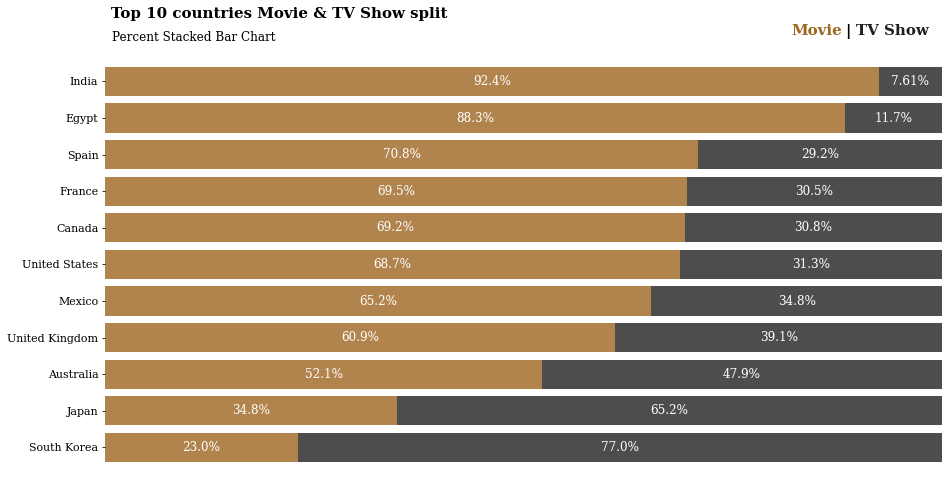

In [41]:
# Horizontal Bar Garph
fig, ax = plt.subplots(1,1,figsize=(15, 8),)

ax.barh(data1_ratio.index, data1_ratio['Movie'], color='#9C661F', alpha=0.8, label='Movie')

ax.barh(data1_ratio.index, data1_ratio['TV Show'], left=data1_ratio['Movie'], color='#221f1f', alpha=0.8, label='TV Show')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data1_ratio.index, fontfamily='serif', fontsize=11)

# Values percentage
for i in data1_ratio.index:
    ax.annotate(f"{data1_ratio['Movie'][i]*100:.3}%", xy=(data1_ratio['Movie'][i]/2, i), va = 'center', ha='center',
                fontsize=12, fontweight='light', fontfamily='serif', color='white')

for i in data1_ratio.index:
    ax.annotate(f"{data1_ratio['TV Show'][i]*100:.3}%", xy=(data1_ratio['Movie'][i] + data1_ratio['TV Show'][i]/2, i),
                va = 'center', ha = 'center',fontsize = 12, fontweight = 'light', fontfamily = 'serif', color='white')
    

fig.text(0.13, 0.93, 'Top 10 countries Movie & TV Show split', fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.131, 0.89, 'Percent Stacked Bar Chart', fontsize=12,fontfamily='serif')   

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_visible(False)
    

fig.text(0.76,0.9,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#9C661F')
fig.text(0.81,0.9,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.82,0.9,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')


plt.show()

We observe that Netflix in India is made up nearly entirely of Movies. The demand for Bollywood and Tollywood movies among Indian consumers is perhaps the leading cause of it. South Korean Netflix, on the other hand, is almost entirely TV Shows. The demand and popularity of Korean TV Series keep increasing day by day, even in the international market. The underlying reasons for the difference in content must be due to market research conducted by Netflix. It is fascinating to see how the split between TV Shows and Movies varies by country. 

## Ratings

Let us put some light on the ratings of the movies/tv shows on the platform. There are:

In [42]:
print('\033[1m', len(movies['rating'].unique()), '\033[0m', 'types of ratings for movies, and')

 14  types of ratings for movies, and


In [43]:
print('\033[1m', len(tv['rating'].unique()), '\033[0m', 'types for TV Shows.')

 9  types for TV Shows.


Let's briefly checks out how ratings are distributed.

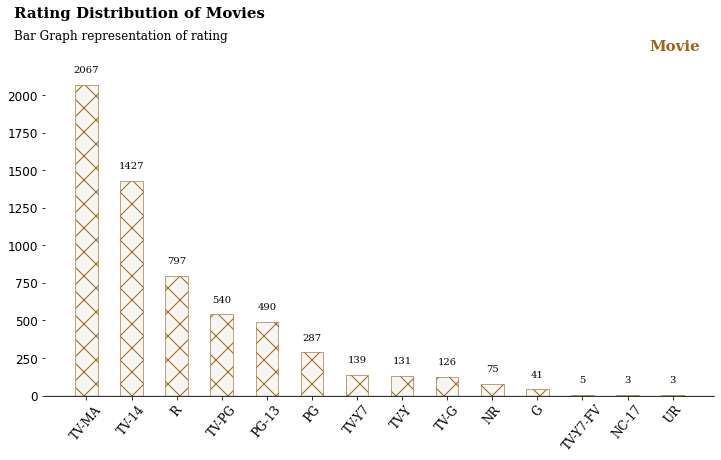

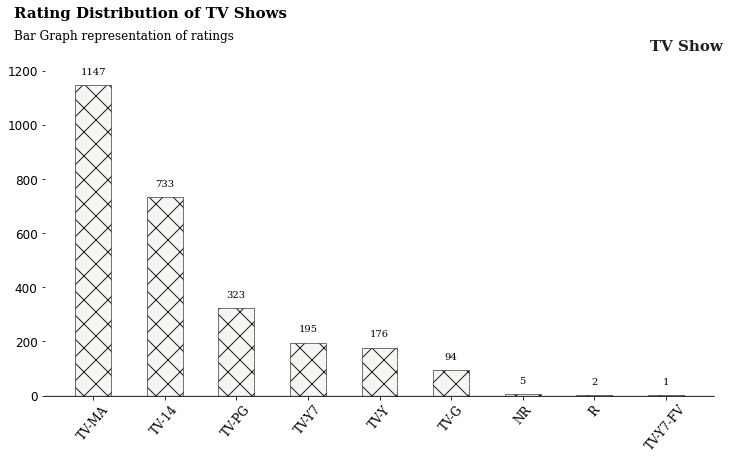

In [44]:
# Movies Rating Bar Garph
movie1 = movies['rating'].value_counts()

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(movie1.index, movie1, width = 0.5, edgecolor = '#9C661F', linewidth = 0.6, color = '#f5f5f1', hatch = 'x')

#annotations
for i in movie1.index:
    ax.annotate(f"{movie1[i]}", xy = (i, movie1[i] + 100), va = 'center', ha = 'center',fontweight = 'light',
                fontfamily = 'serif')

# Removing borders from plot
for i in ['top', 'left', 'right']:
    ax.spines[i].set_visible(False)
    
# Tick labels
ax.set_xticklabels(movie1.index, fontfamily='serif', rotation=50)

# Title and Subtitle
fig.text(0.09, 1, 'Rating Distribution of Movies', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.95, 'Bar Graph representation of rating', fontsize=12, fontweight='light', fontfamily='serif')
fig.text(0.825,0.924,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#9C661F')

    
# thickening the bottom line
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
ax.tick_params(axis='both', which='major', labelsize=12)

# TV Shows Rating Bar Garph
tv1 = tv['rating'].value_counts()

fig1, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.bar(tv1.index, tv1, width = 0.5, edgecolor = '#221f1f', linewidth = 0.6, color = '#f5f5f1', hatch = 'x')

#annotations
for i in tv1.index:
    ax1.annotate(f"{tv1[i]}", xy = (i, tv1[i] + 50), va = 'center', ha = 'center',fontweight = 'light',
                fontfamily = 'serif')

# Removing borders from plot
for i in ['top', 'left', 'right']:
    ax1.spines[i].set_visible(False)
    
# Tick labels
ax1.set_xticklabels(tv1.index, fontfamily='serif', rotation=50)

# Title and Subtitle
fig1.text(0.09, 1, 'Rating Distribution of TV Shows', fontsize=15, fontweight='bold', fontfamily='serif')
fig1.text(0.09, 0.95, 'Bar Graph representation of ratings', fontsize=12, fontweight='light', fontfamily='serif')
fig1.text(0.825,0.924,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')
    
# thickening the bottom line
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
ax1.tick_params(axis='both', which='major', labelsize=12)

plt.show()

Let's plot them in the same diagram.

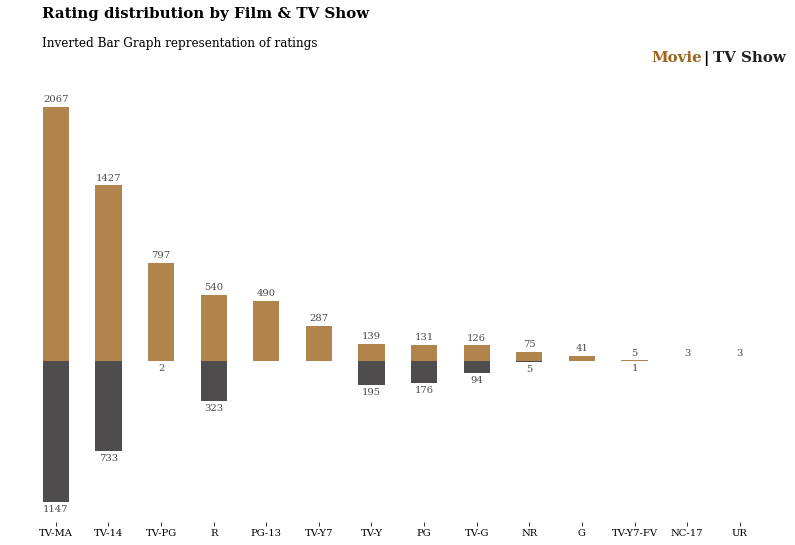

In [45]:
fig, ax = plt.subplots(1,1, figsize=(14, 8))
ax.bar(movie1.index, movie1, width=0.5, color='#9C661F', alpha=0.8, label='Movie')
ax.bar(tv1.index, -tv1, width=0.5, color='#221f1f', alpha=0.8, label='TV Show')

# Annotations
for i in tv1.index:
    ax.annotate(f"{tv1[i]}", xy=(i, -tv1[i] - 60), va = 'center', ha='center',fontweight='light', fontfamily='serif', 
                color='#4a4a4a')   

for i in movie1.index:
    ax.annotate(f"{movie1[i]}", xy=(i, movie1[i] + 60), va = 'center', ha='center',fontweight='light', fontfamily='serif',
                color='#4a4a4a')


for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_visible(False)

ax.set_xticklabels(df['rating'].value_counts().index, fontfamily='serif')
ax.set_yticks([])    

ax.legend().set_visible(False)
fig.text(0.16, 1, 'Rating distribution by Film & TV Show', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.16, 0.95, 'Inverted Bar Graph representation of ratings', fontsize=12, fontweight='light', fontfamily='serif')
fig.text(0.764,0.924,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#9C661F')
fig.text(0.815,0.924,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.825,0.924,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

plt.show()

We observe that some ratings only apply for movies. There are a lot of movies and TV shows that are classified into two categories, TV-MA (TV Mature Audience) and TV-14, which give a general idea to the target audience.

## Content Added

There are tons of movies/tv shows released every year, but they aren't readily available on platforms for consumers to watch. We will examine how the platform has added content since it started operations in this segment.

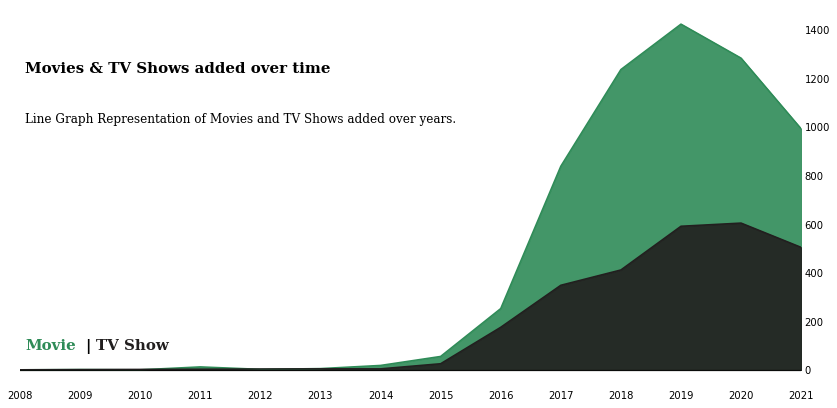

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
color = ["#2E8B57", "#221f1f"]

for i, mt in enumerate(df['type'].value_counts().index):
    mty = df[df['type'] == mt]['year_added'].value_counts().sort_index()
    ax.plot(mty.index, mty, color = color[i], label = mt)
    ax.fill_between(mty.index, 0, mty, color = color[i], alpha=0.9)
    
ax.yaxis.tick_right()
ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

for i in ['top', 'right','bottom','left']:
    ax.spines[i].set_visible(False)

ax.grid(False)

ax.set_xlim(2008,2021)
plt.xticks(np.arange(2008, 2022, 1))

fig.text(0.13, 0.75, 'Movies & TV Shows added over time', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.65, 'Line Graph Representation of Movies and TV Shows added over years.', fontsize=12, fontweight='light',
         fontfamily='serif')
fig.text(0.13,0.2,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#2E8B57')
fig.text(0.19,0.2,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.2,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

In the above graph, we may observe a slow start for Netflix over several years. 

There has been an increase since 2016 after things started to pick up in 2015. Netflix has increased movies more dramatically than TV Shows, as a result of Netflix focusing more attention on increasing movies than TV shows. It may be due to the market research and availability of the content.

The content addition has slowed down from 2020, probably due to the COVID-19 pandemic.

Now we have seen how over a time period; Netflix have increases its vast collection of its content. Let’s explore how they add new content to their collection in a year. Are there certain months that on average tends to enjoy more content being added?

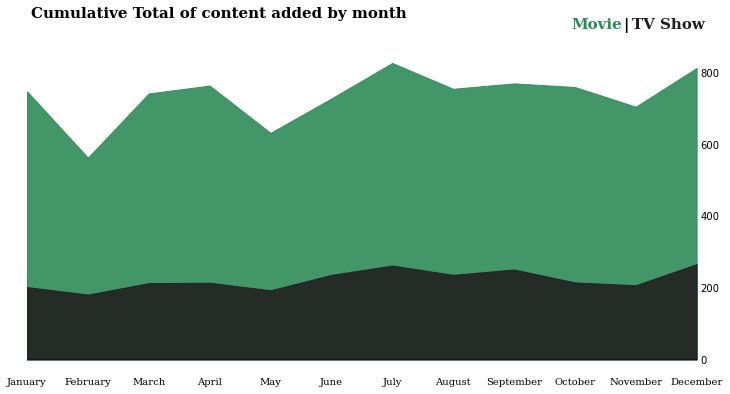

In [47]:
data3 = df.groupby('type')['month_added'].value_counts().unstack().fillna(0).loc[['TV Show','Movie']].cumsum(axis=0).T

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ["#2E8B57", "#221f1f"]

for i, mt in enumerate(df['type'].value_counts().index):
    mtm = data3[mt]
    ax.fill_between(mtm.index, 0, mtm, color = color[i], label = mt, alpha=0.9)
    

ax.yaxis.tick_right()
ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .4)


for i in ['top', 'right','bottom','left']:
    ax.spines[i].set_visible(False)

ax.grid(False)
ax.set_xticklabels(data3.index, fontfamily = 'serif', rotation = 0)
ax.margins(x = 0) # remove white spaces next to margins

fig.text(0.13, 0.95, 'Cumulative Total of content added by month', fontsize = 15, fontweight = 'bold', fontfamily = 'serif')
fig.text(0.755,0.924,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#2E8B57')
fig.text(0.815,0.924,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.825,0.924,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')


ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

The above trend shows that the month of July and December are the two months in which, on an average, most new content is added. July is the month teenagers enjoy their summer holidays in most countries, and in December people have a lot of time off from work over the period.

February and May, on the other hand, have the least average count of the new content addition.

## Duration & Release Year

After going through the content, let us focus on the duration of it. Below are some graphs which will give us an idea about the average content and it's duration. 

Let's find the trend the **Movies** duration follow with the help of release year. 

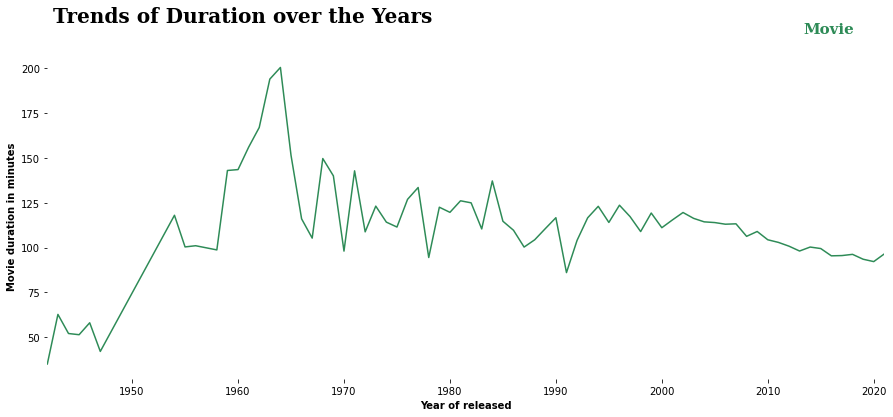

In [48]:
duration_year = movies.groupby(['release_year']).mean()
duration_year = duration_year.sort_index()


fig, ax = plt.subplots(1, 1, figsize=(15, 6))

sns.lineplot(x= duration_year.index, y= duration_year.duration.values, color = '#2E8B57')

plt.ylabel('Movie duration in minutes', fontweight = 'bold')
plt.xlabel('Year of released', fontweight = 'bold')



for i in ['top', 'right','bottom','left']:
    ax.spines[i].set_visible(False)


ax.margins(x = 0) # remove white spaces next to margins

fig.text(0.13, 0.95, "Trends of Duration over the Years", fontsize = 20, fontweight = 'bold', fontfamily = 'serif')
fig.text(0.825,0.924,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#2E8B57')




plt.show()

Movies after the 2000s show an average trend of 125 mins (2.08 hrs), which is also decreasing as new movies are added over the years.

 Movies in 40s and 50s have the least average duration, whereas movies in 60s and 70s have the highest average duration.

After movies, let us give our focus to **TV Shows**:

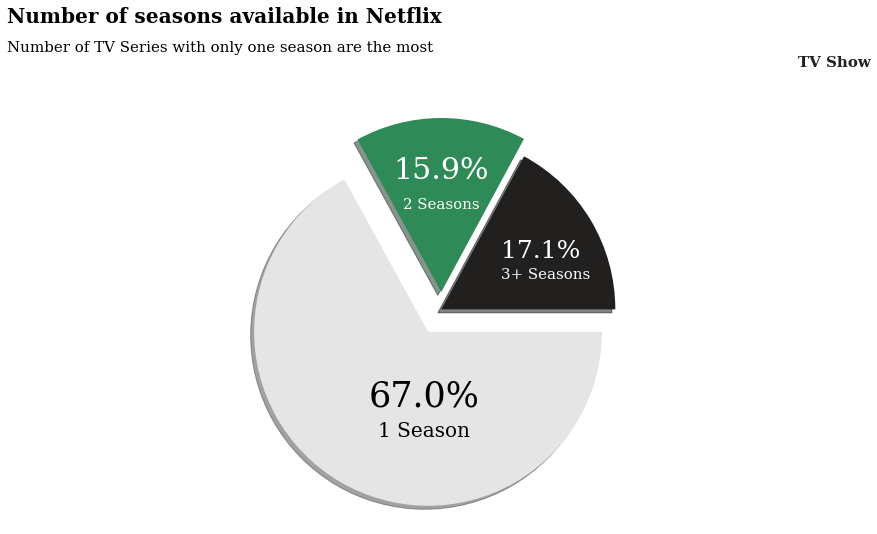

In [49]:
## Pie plot
fig, ax = plt.subplots(1,1,figsize=(12, 8))
labels = ['3+ Seasons', '2 Seasons', '1 Season']
sizes = [ sum(tv['duration'].value_counts()[2:]), tv['duration'].value_counts()[2], tv['duration'].value_counts()[1]]
explode = (0, 0.1, 0.15)
ax.pie(sizes, explode = explode, colors = ['#221f1f', '#2E8B57', '#E5E5E5'], shadow = True)
    
# Annotations
ax.annotate(f"{round(sizes[0]/(sizes[0]+sizes[1]+sizes[2]) * 100,1)}%", xy=(0.80, 0.3), ha='right',fontsize=25, 
                   fontweight='light', fontfamily='serif', color='white')

ax.annotate(f"{labels[0]}", xy=(0.60, 0.2), va = 'center', ha='center',fontsize=15, fontweight='light',fontfamily='serif',
              color = 'white')
    
ax.annotate(f"{round(sizes[1]/(sizes[0]+sizes[1]+sizes[2]) * 100,1)}%", xy=(0.0, 0.8), va = 'center', ha='center',fontsize=30,
                   fontweight='light', fontfamily='serif', color='white')  

ax.annotate(f"{labels[1]}", xy=(0.0, 0.6), va = 'center', ha='center',fontsize=15, fontweight='light',fontfamily='serif',
              color = 'white')

ax.annotate(f"{round(sizes[2]/(sizes[0]+sizes[1]+sizes[2]) * 100,1)}%", xy=(-0.1, -0.5), va = 'center', ha='center',fontsize=35,
                   fontweight='light', fontfamily='serif', color='black')  

ax.annotate(f"{labels[2]}", xy=(-0.1, -0.7), va = 'center', ha='center',fontsize=20, fontweight='light',fontfamily='serif',
              color = 'black')

# Removing borders
for i in ['top', 'left', 'right', 'bottom']:
     ax.spines[i].set_visible(False)

# Title and Subtitles
fig.text(0.01, 1, 'Number of seasons available in Netflix', fontsize=20, fontweight='bold', fontfamily='serif')
fig.text(0.01, 0.95, 'Number of TV Series with only one season are the most', fontsize=15, fontweight='light', 
        fontfamily='serif')
fig.text(0.925,0.924,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

plt.show()

Most of the tv series available on the platform comprises only 1 season. It's surprising to see that series with more than 3 seasons are so less. 

## Title

In the previous segment, we have explored how the duration of Movies and TV Shows trends. Let's explore the title column and get some valuable insights.

In [50]:
column = ['title', 'duration']
most_tv = tv[column].sort_values(by = 'duration', ascending = False).reset_index(drop = True)[:10]
most_movie = movies[column].sort_values(by = 'duration', ascending = False).reset_index(drop = True)[:10]

In [51]:

def most(data, title):
    
    # Title and Color
    if title == "Movies":
        t, c, m = ('Movie', '#2E8B57', 6)
    else:
        t,c, m = ('TV Show', '#221f1f', 0.5)
    
    # BarPlot
    fig, ax = plt.subplots(1,1, figsize=(12, 6))

    ax.bar(data['title'], data['duration'], width = 0.5, edgecolor = c, linewidth = 0.6, color = '#f5f5f1', hatch='\/')

    #annotations
    for i in data.index:
        ax.annotate(f"{data['duration'][i]}", xy = (i, data['duration'][i] + m), va = 'center', ha = 'center',
                    fontweight = 'light', fontfamily = 'serif')

    # Removing borders from plot
    for i in ['top', 'left', 'right']:
        ax.spines[i].set_visible(False)
    
    # Tick labels
    ax.set_xticklabels(data['title'], fontfamily='serif', rotation=50, fontweight='bold')

    # Title and Subtitle
    fig.text(0.09, 1, 'Top Ten {} with most Duration'.format(title), fontsize=20, fontweight='bold', fontfamily='serif')
    fig.text(0.925,0.924,"{}".format(t), fontweight="bold", fontfamily='serif', fontsize=15, color = c)
    
    # thickening the bottom line
    plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
    ax.tick_params(axis='both', which='major', labelsize=10)

    plt.show()

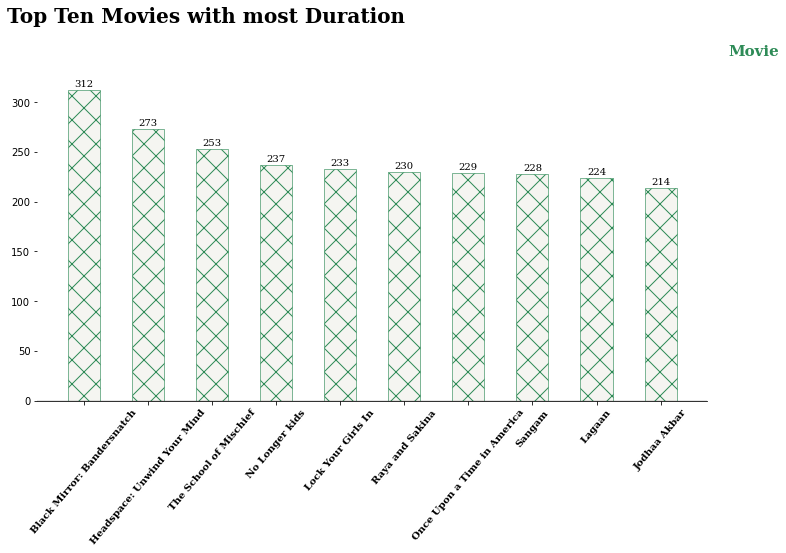

In [52]:
most(most_movie, "Movies")

The movie with the highest duration is **Black Mirror: Bandersnatch** (312 mins, i.e., 5.2 hrs), followed by **Headspace: Unwind Your Mind** (273 mins) and **The School of Mischief** (253 mins).

The shortest movie available on Netflix is: 

In [53]:
movies.loc[movies['duration'] == movies['duration'].min()].drop(['primary_country', 'cast', 'description', 'count',
                                                                'year_added', 'month_added'], axis = 1)

show_id   type   title                           director        country  \
3777   s3778  Movie  Silent  Limbert Fabian, Brandon Oldenburg  United States   

        date_added  release_year rating  duration  \
3777  June 4, 2019          2014   TV-Y         3   

                                             genre target_ages  
3777  [Children & Family Movies, Sci-Fi & Fantasy]        Kids

the movie **Silent** with a duration of 3 mins.

It is fascinating to see the difference between the durations of the movies present in Netflix. They have movies as long as 312 mins (5.2 hrs) and as short as 3 mins !!

Let’s have a look at the TV Series.

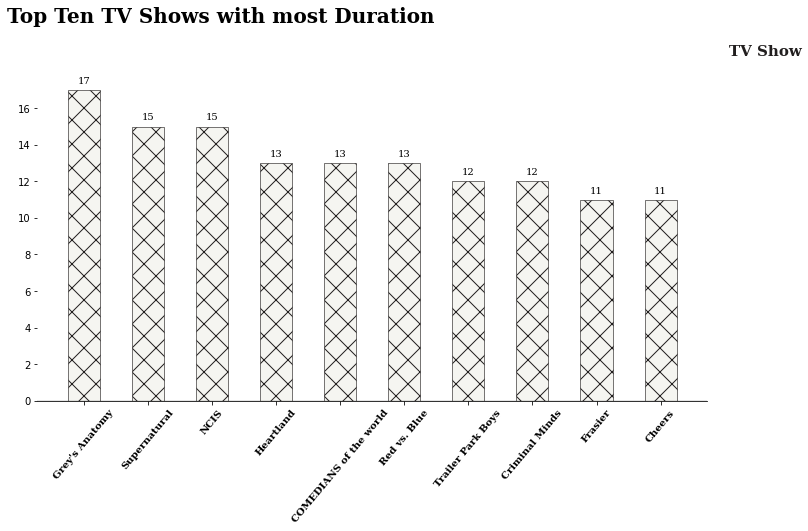

In [54]:
most(most_tv, "TV Shows")

The TV series part shows that TV show with the most seasons is **Grey’s Anatomy**, with 17 seasons, followed by **Supernatural** and **NCIS**, with 15 seasons each.

Below is a WordCloud created out of the Title column to get a review of it.

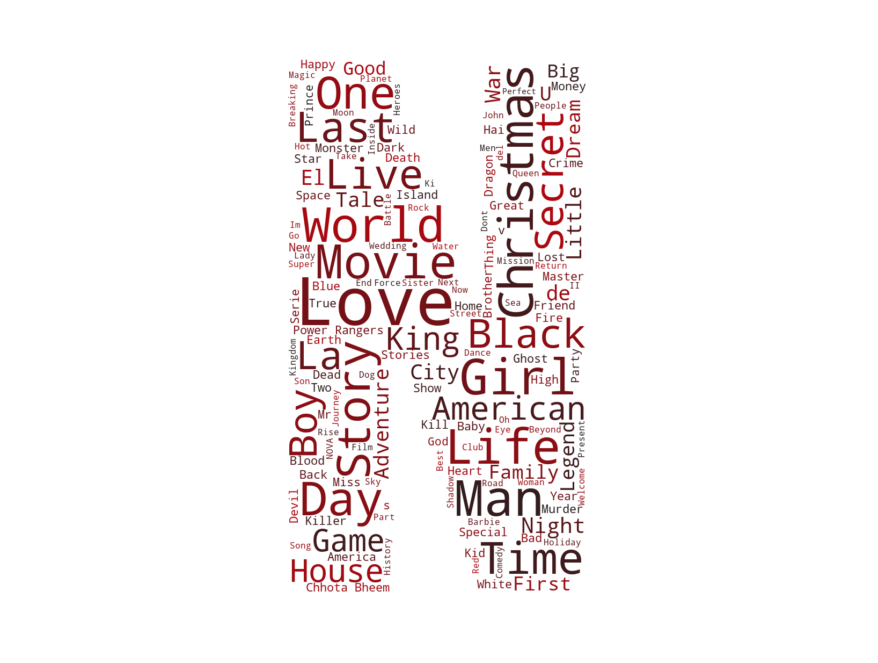

In [55]:
# Custom colour map based on Title
cmap = cls.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710'])

text = str(list(df['title'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')

mask = np.array(Image.open('Netflix-N-logo.png'))

wordcloud = WordCloud(background_color = 'white', width = 500,  height = 200,colormap=cmap, max_words = 150,
                      mask = mask).generate(text)

plt.figure( figsize=(12,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Cast

The popularity of a Movie/TV show depends upon the cast that is playing its roles. Let us explore and see which actors have most of their content available on Netflix.

*(NOTE: This information may not be 100% accurate because of the non-availability of full information for every row.)*

Let's see the top movie actors from the top ten countries.

In [56]:
top_ten = []
countries_actor = list(df['country'].value_counts()[:10].index)

for countries, c in zip(countries_actor, ['\033[95m', '\033[36m', '\033[94m', '\033[96m', '\033[92m', '\033[93m',
                                          '\033[91m', '\033[95m', '\033[96m', '\033[91m']):
    tmp = df[df['country'] == countries].copy()
    tmp = tmp.reset_index(drop=True)
    actors= []
    for i in range(len(tmp)):
        if tmp.loc[i,'cast'] =='No Cast Specified' or type(tmp.loc[i,'cast']) !=str:
            continue
        elif "," not in tmp.loc[i,'cast']:
            actors.append(tmp.loc[i,'cast'])
        else:
            for j in tmp.loc[i,'cast'].split(", "):
                actors.append(j)
    print('\033[1m', c, countries, " : ",sorted(Counter(actors).items(), key= lambda x :x[1],reverse=True)[0], '\033[0m')
    top_ten.append(sorted(Counter(actors).items(), key= lambda x :x[1],reverse=True)[:10])

  United States  :  ('Samuel L. Jackson', 21) 
  India  :  ('Anupam Kher', 40) 
  United Kingdom  :  ('John Cleese', 11) 
  Japan  :  ('Takahiro Sakurai', 29) 
  South Korea  :  ('Sung Dong-il', 6) 
  Canada  :  ('John Paul Tremblay', 14) 
  Spain  :  ('Mario Casas', 10) 
  France  :  ('Wille Lindberg', 5) 
  Egypt  :  ('Hassan Hosny', 14) 
  Mexico  :  ('Humberto Busto', 5) 


**Anupam Kher** from India has the most content available on the platform, even though India is in the second position in the contribution of content.

Let's see the top celebs with the most content on the platform of the top ten countries.

In [57]:
celebrities = []
for i in range(10):
    country = countries_actor[i]
    for j in range(10):
        celebs, count = top_ten[i][j]
        celebrities.append([country, celebs, count])
        
na_celeb = pd.DataFrame(celebrities, columns = ['countries', 'celebs', 'count'])

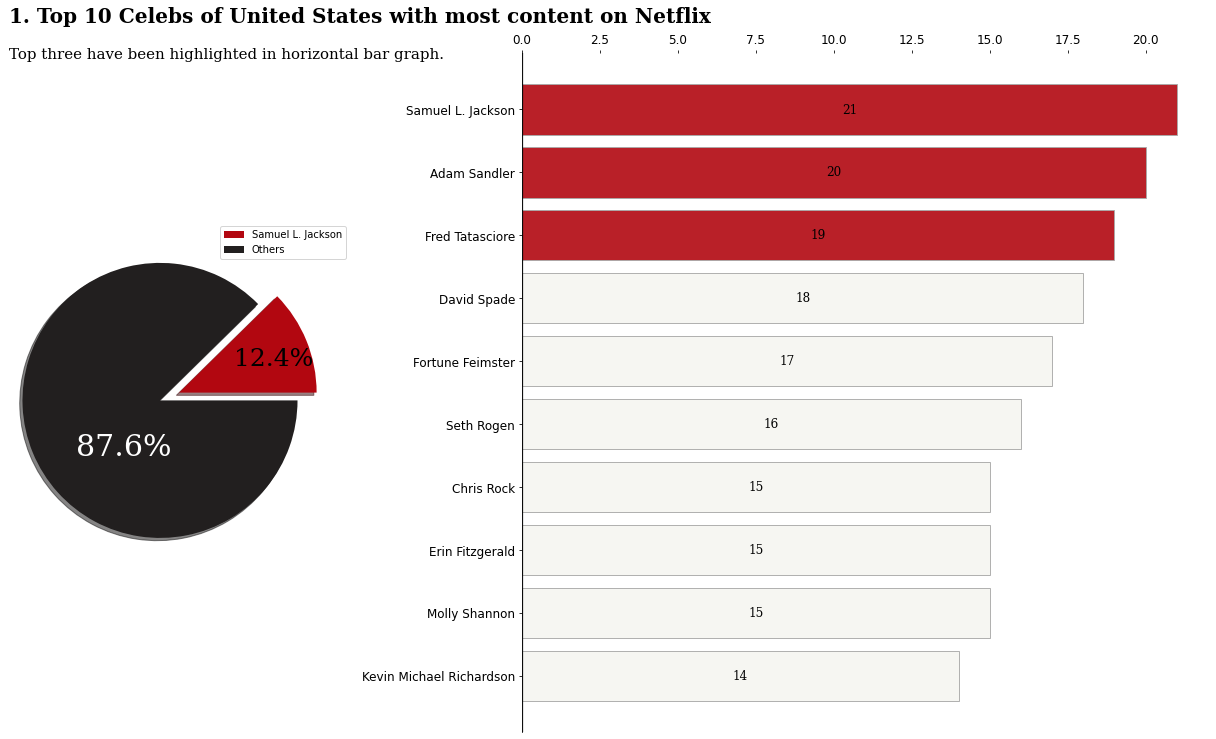

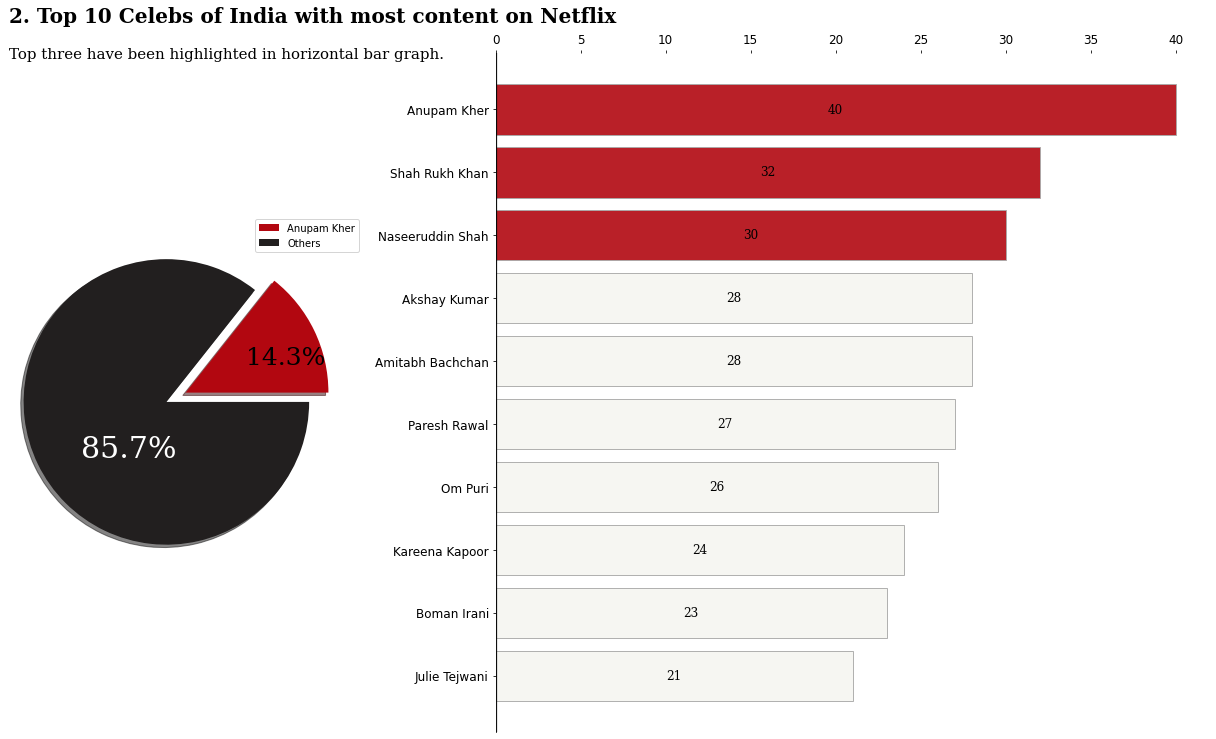

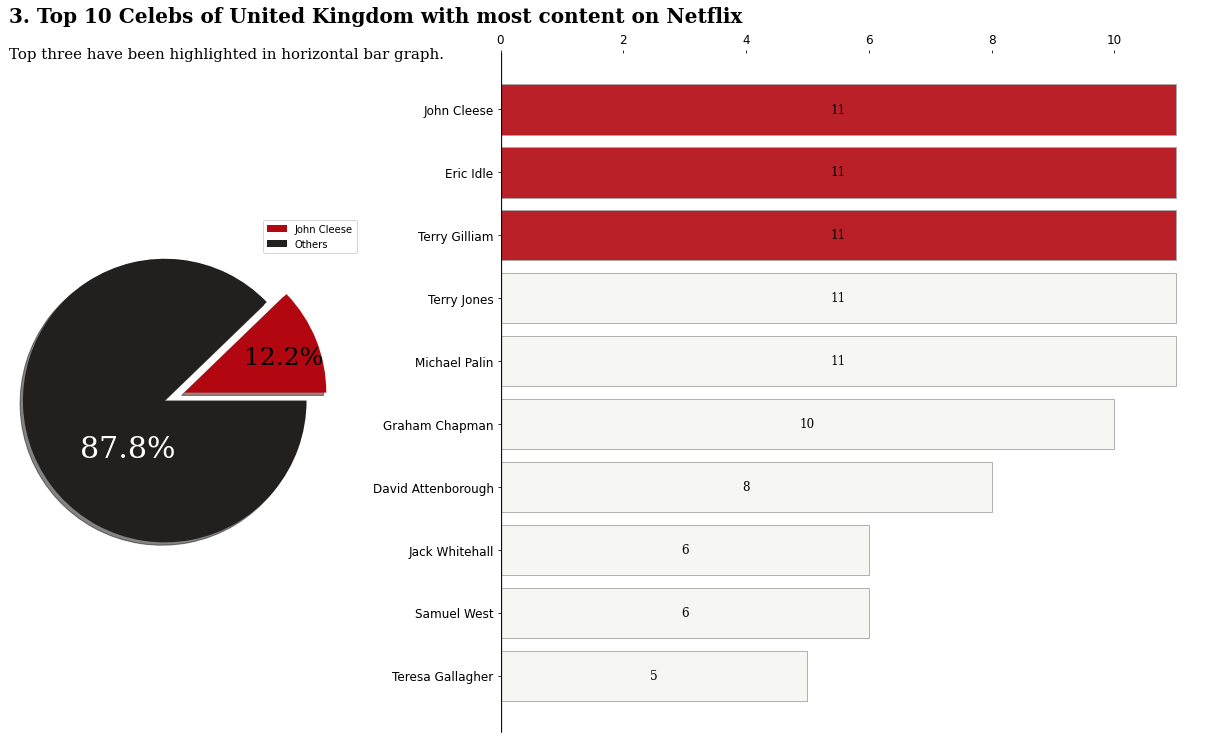

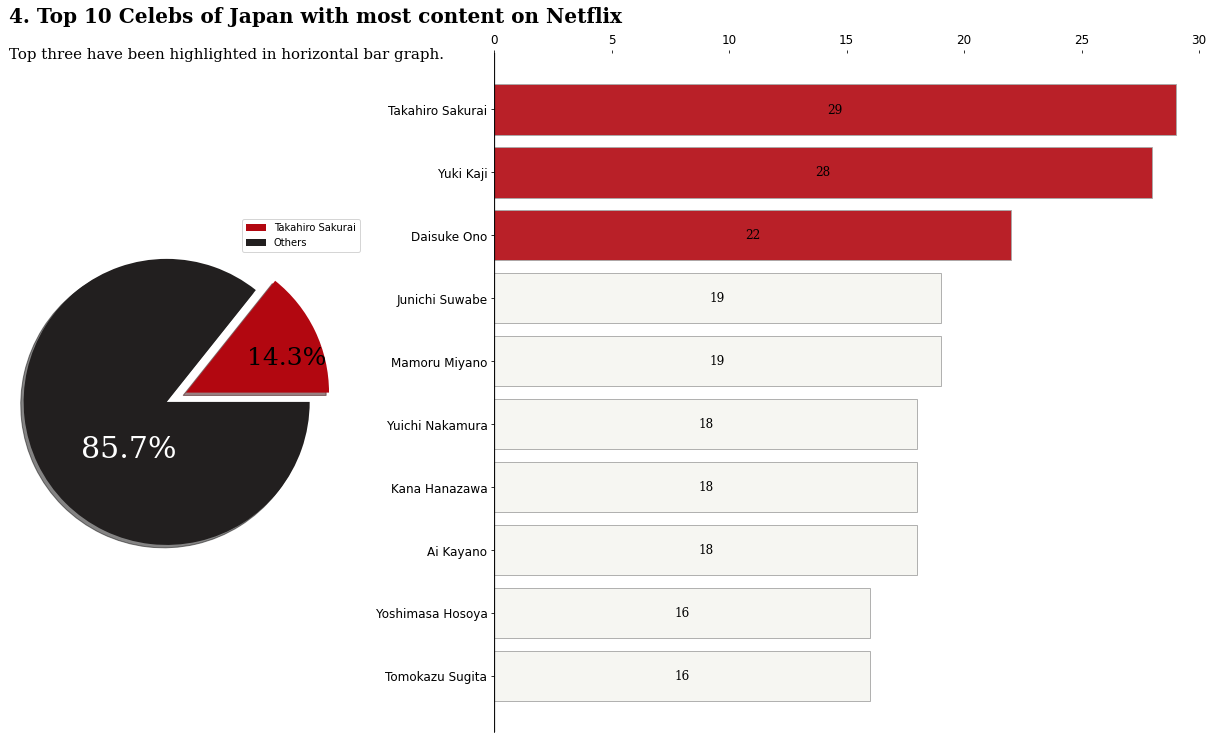

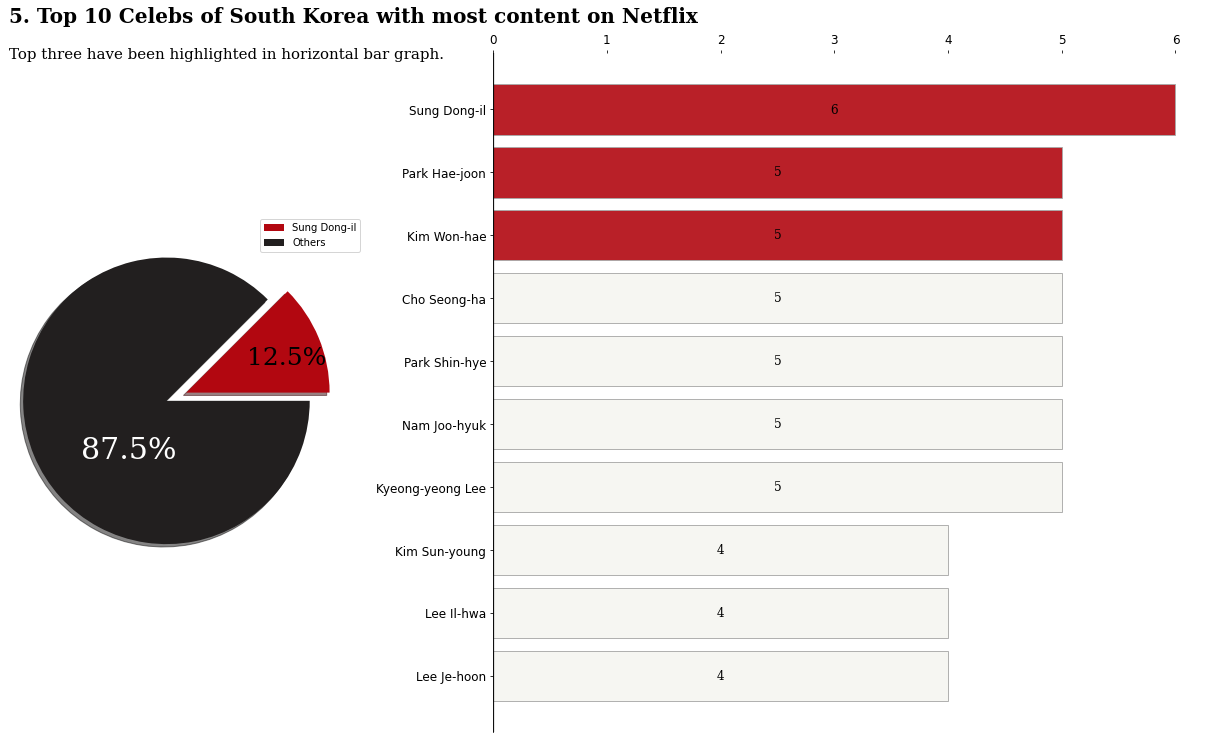

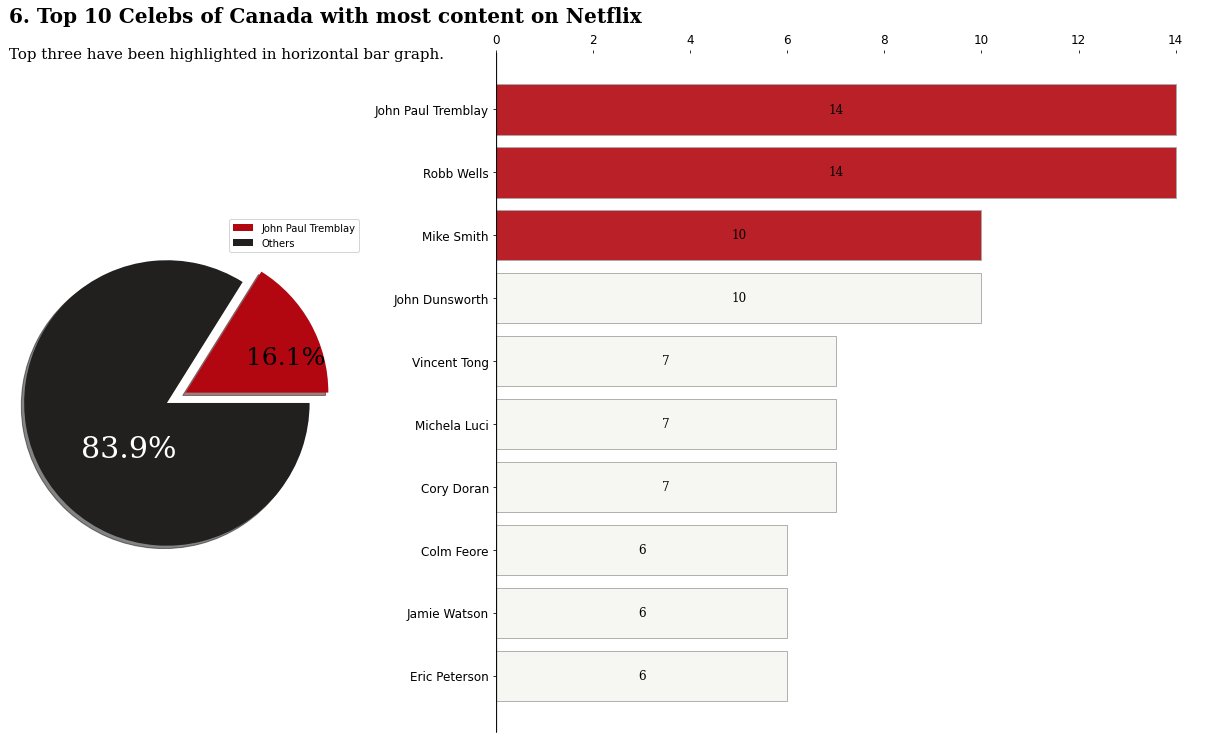

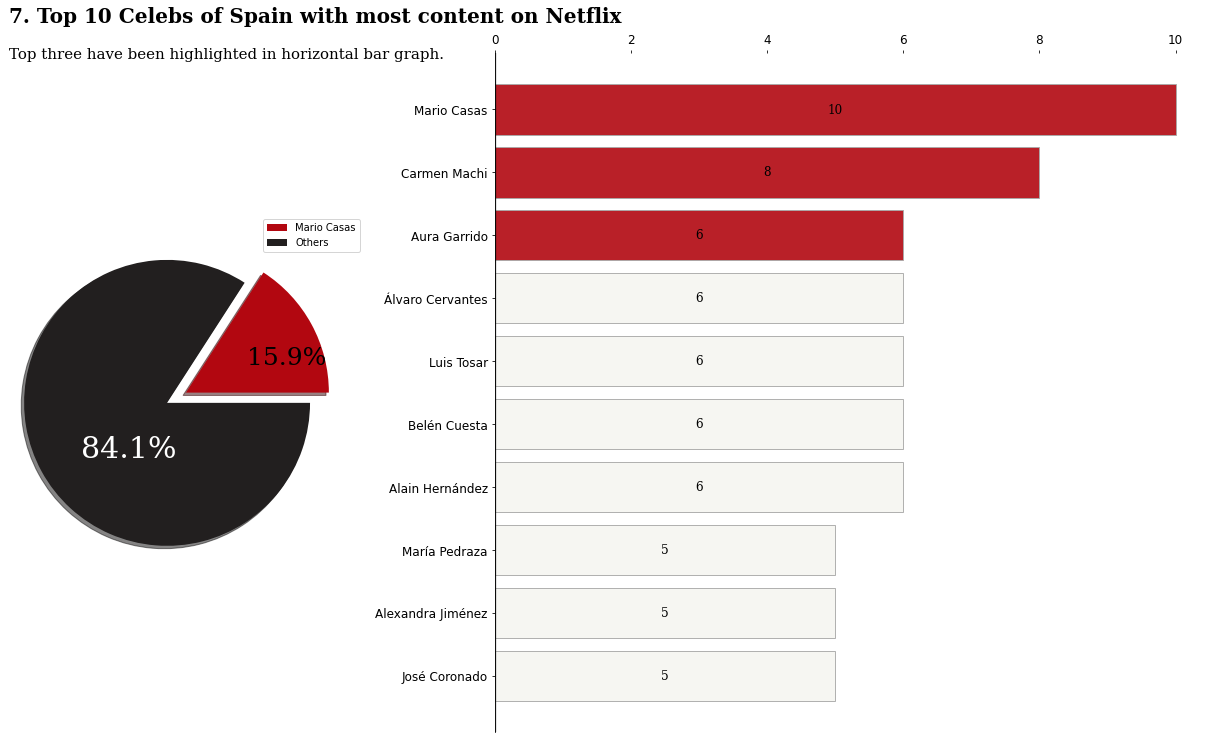

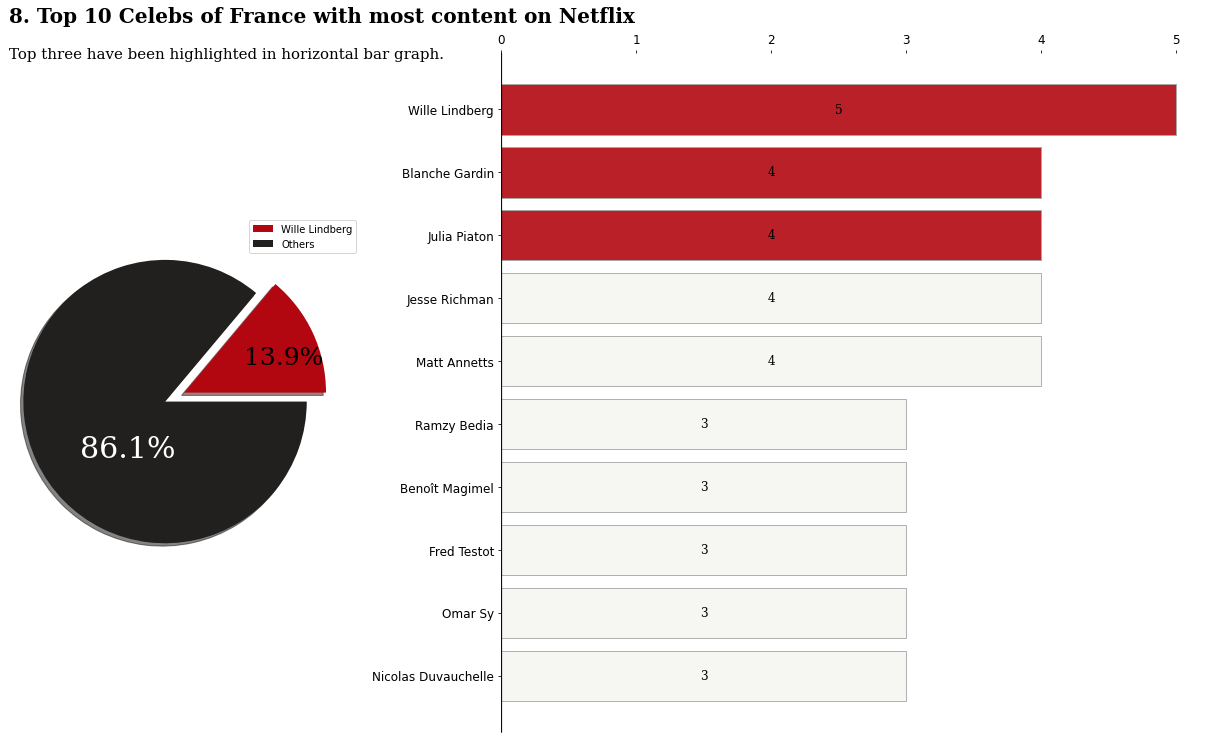

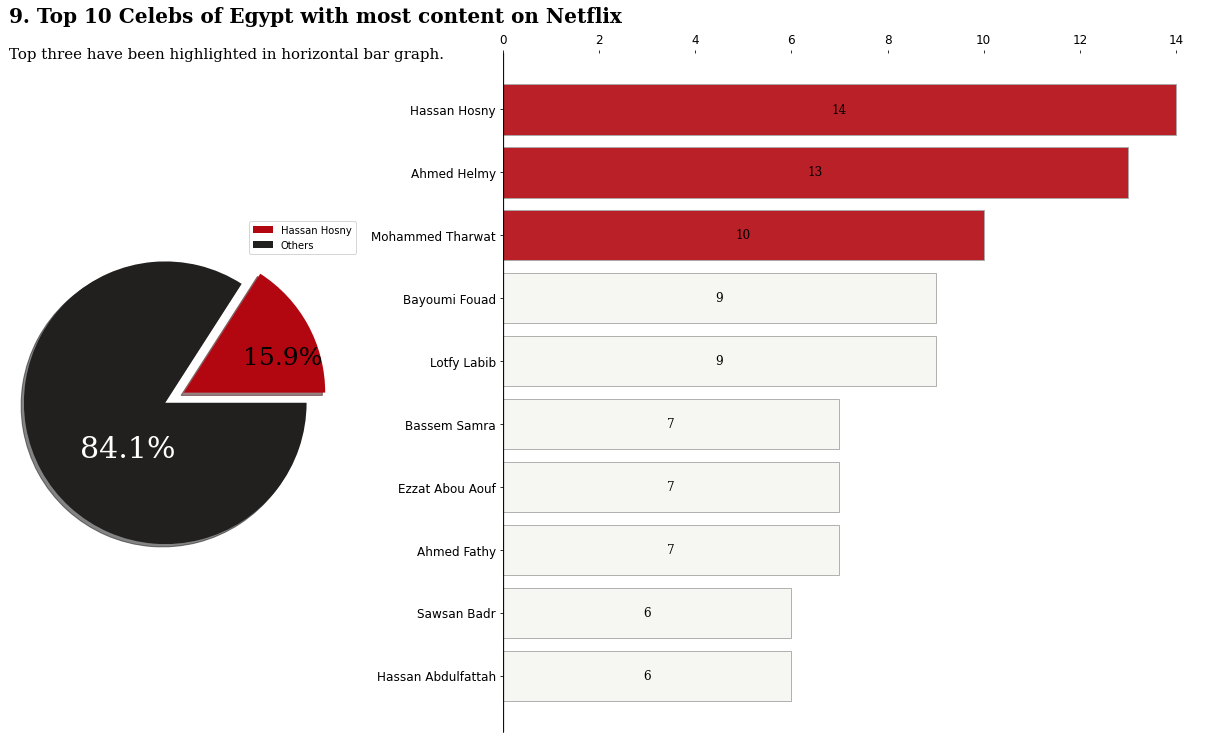

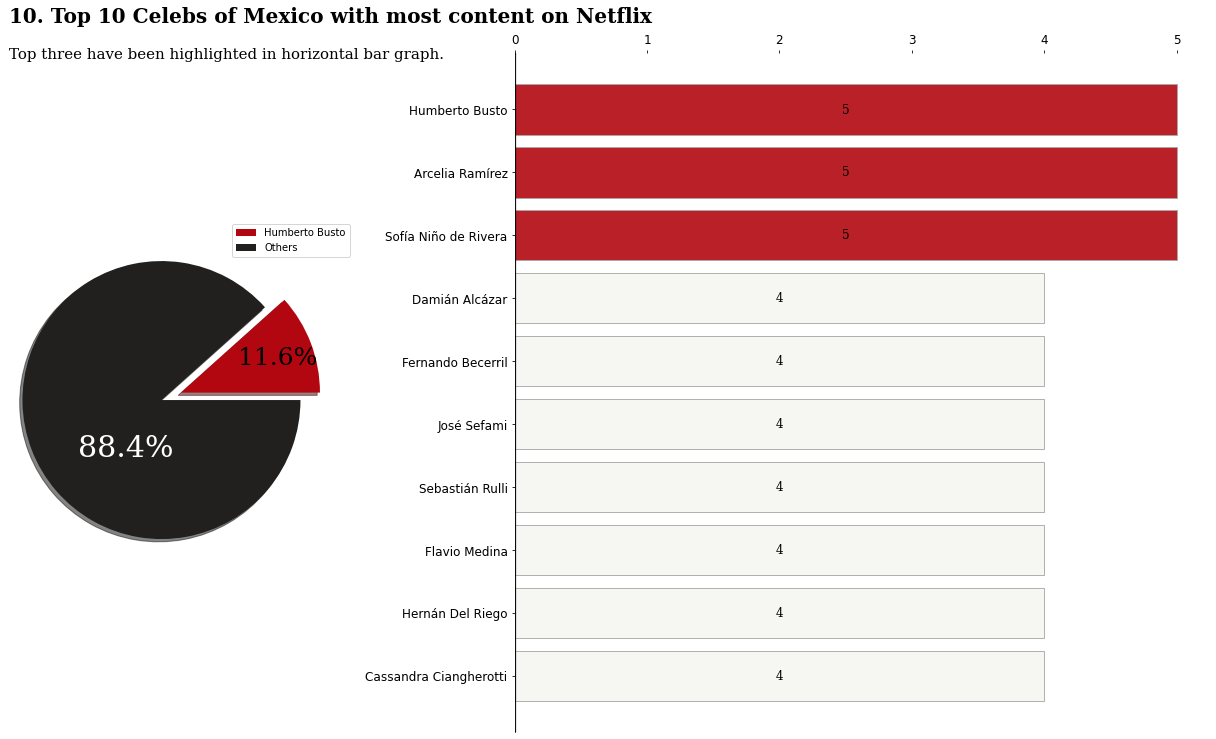

In [58]:
for i in range(10):
    data4 = na_celeb[na_celeb['countries'] == countries_actor[i]].reset_index(drop = True)
    index = i+1
    country = data4['countries'][0]
    
    labels = [data4['celebs'][0], 'Others']
    sizes = [data4['count'][0], sum(data4['count'][1:])]
    explode = (0, 0.15)
    
    # For horizontal bar graph
    color_map1 = ['#f5f5f1' for _ in range(10)]
    color_map1[0] = color_map1[1] = color_map1[2] = '#b20710'
    
    fig, ax = plt.subplots(1,2, figsize = (17,10), gridspec_kw={'width_ratios': [1, 2]})
    
    ## Pie plot
    ax[0].pie(sizes, explode = explode, colors=['#b20710', '#221f1f'], shadow = True)
    ax[0].legend(labels, loc="best")
    
    # Plotting Pie Chart values
    ax[0].annotate(f"{round(sizes[0]/(sizes[0]+sizes[1]) * 100,1)}%", xy=(0.98, 0.2), ha='right',fontsize=25, 
                   fontweight='light', fontfamily='serif', color='black')

    ax[0].annotate(f"{round(sizes[1]/(sizes[0]+sizes[1]) * 100,1)}%", xy=(-0.4, -0.4), va = 'center', ha='center',fontsize=30,
                   fontweight='light', fontfamily='serif', color='white')


    # Removing borders
    for i in ['top', 'left', 'right', 'bottom']:
        ax[0].spines[i].set_visible(False)

    
    # Horizontal Bar Graph

    ax[1].barh(data4['celebs'], data4['count'], color = color_map1, alpha=0.9, edgecolor = 'darkgray')

    for i in data4.index:
        ax[1].annotate(f"{data4['count'][i]}", xy = (data4['count'][i]/2, i), va = 'center', ha = 'center', fontsize=12,
                   fontweight = 'light', fontfamily = 'serif')

    # Removing borders from plot
    for i in ['top', 'bottom', 'right']:
        ax[1].spines[i].set_visible(False)

    # Title and Subtitle
    fig.text(0.01, 1, '{}. Top 10 Celebs of {} with most content on Netflix'.format(index, country), fontsize=20,
             fontweight='bold', fontfamily='serif')
    fig.text(0.01, 0.95, 'Top three have been highlighted in horizontal bar graph.', fontsize=15, fontweight='light', 
             fontfamily='serif')    

    # thickening the side line and inverting the axis
    plt.axvline(x = 0, color = 'black', linewidth = 1.3, alpha = .7)
    ax[1].tick_params(axis='both', which='major', labelsize=12)
    ax[1].xaxis.tick_top()
    ax[1].invert_yaxis()

    plt.tight_layout()
    plt.show()
    print('\n')
    print('\n')

Even though the USA is the top content creator, there is no celeb who is dominating the market. On the other hand, in India contents of **Anupam Kher** (40) are mostly available on the platform followed by **Shahrukh Khan** (32) and **Naseeruddin Shah** (30).

Let's have a look at the type of content the actors have worked on:

In [59]:
movie_ten = []
countries_movie = list(movies['country'].value_counts()[:5].index)

for countries, c in zip(countries_movie, ['\033[95m', '\033[36m', '\033[94m', '\033[91m', '\033[92m']):
    tmp = movies[movies['country'] == countries].copy()
    tmp = tmp.reset_index(drop=True)
    actors= []
    for i in range(len(tmp)):
        if tmp.loc[i,'cast'] =='No Cast Specified' or type(tmp.loc[i,'cast']) !=str:
            continue
        elif "," not in tmp.loc[i,'cast']:
            actors.append(tmp.loc[i,'cast'])
        else:
            for j in tmp.loc[i,'cast'].split(", "):
                actors.append(j)
    print('\033[1m', c, countries, " : ",sorted(Counter(actors).items(), key= lambda x :x[1],reverse=True)[0], '\033[1m')
    movie_ten.append(sorted(Counter(actors).items(), key= lambda x :x[1],reverse=True)[:10])

  United States  :  ('Adam Sandler', 20) 
  India  :  ('Anupam Kher', 40) 
  United Kingdom  :  ('John Cleese', 8) 
  Canada  :  ('Robb Wells', 10) 
  Spain  :  ('Mario Casas', 8) 


In [60]:
movie_celeb = []
for i in range(5):
    country = countries_movie[i]
    for j in range(10):
        celebs, count = movie_ten[i][j]
        movie_celeb.append([country, celebs, count])
        
na_movie_celeb = pd.DataFrame(movie_celeb, columns = ['countries', 'celebs', 'count'])

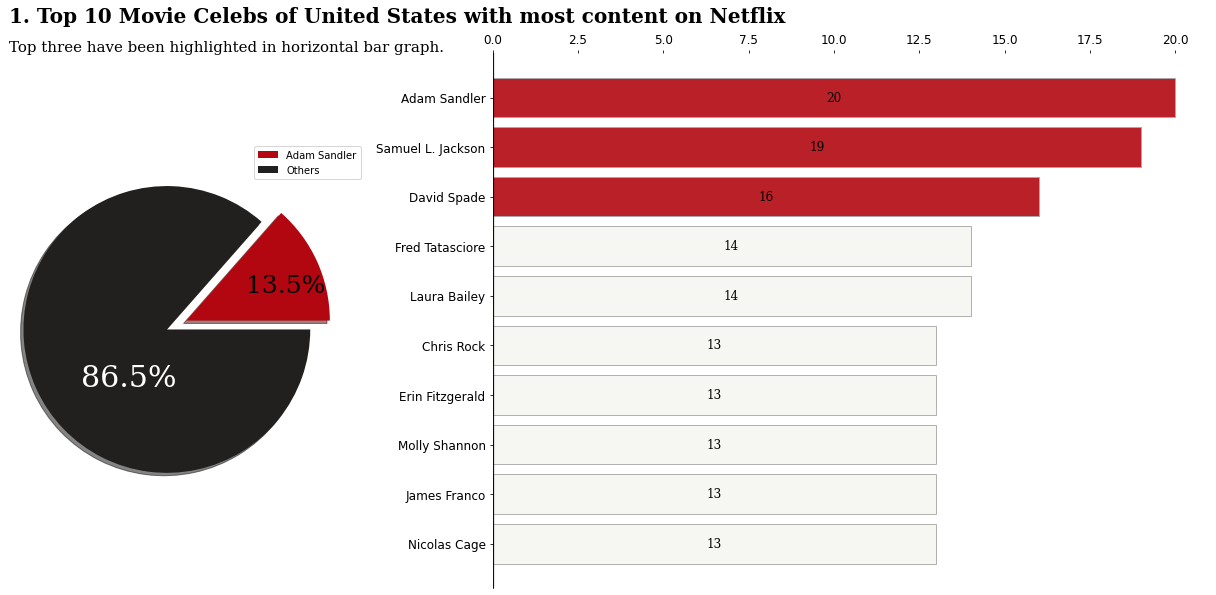

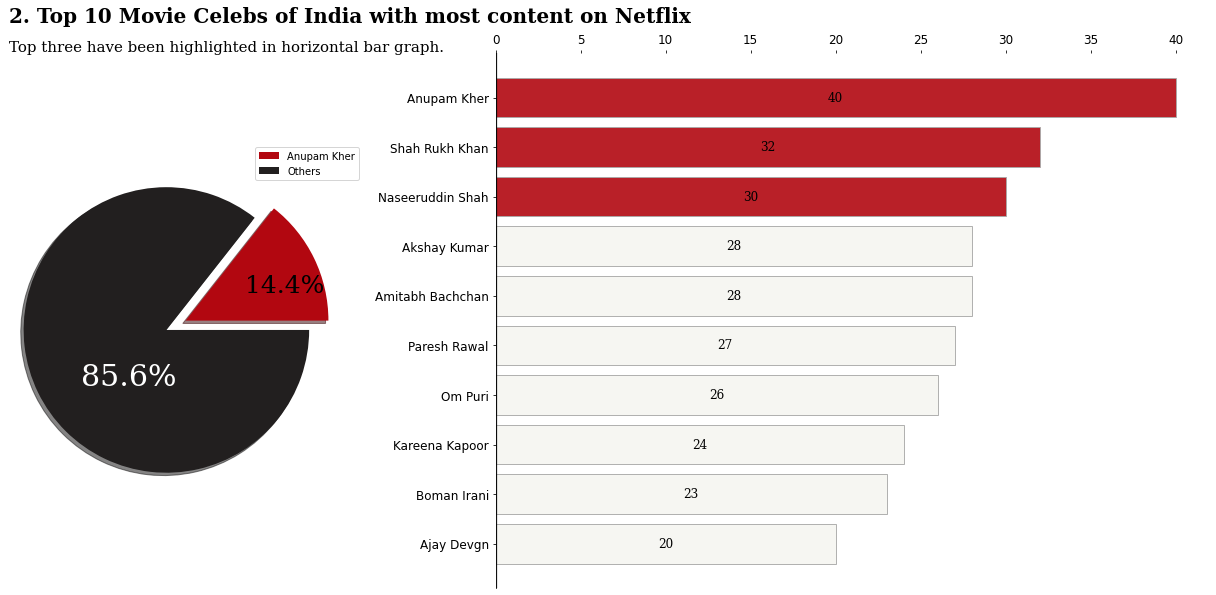

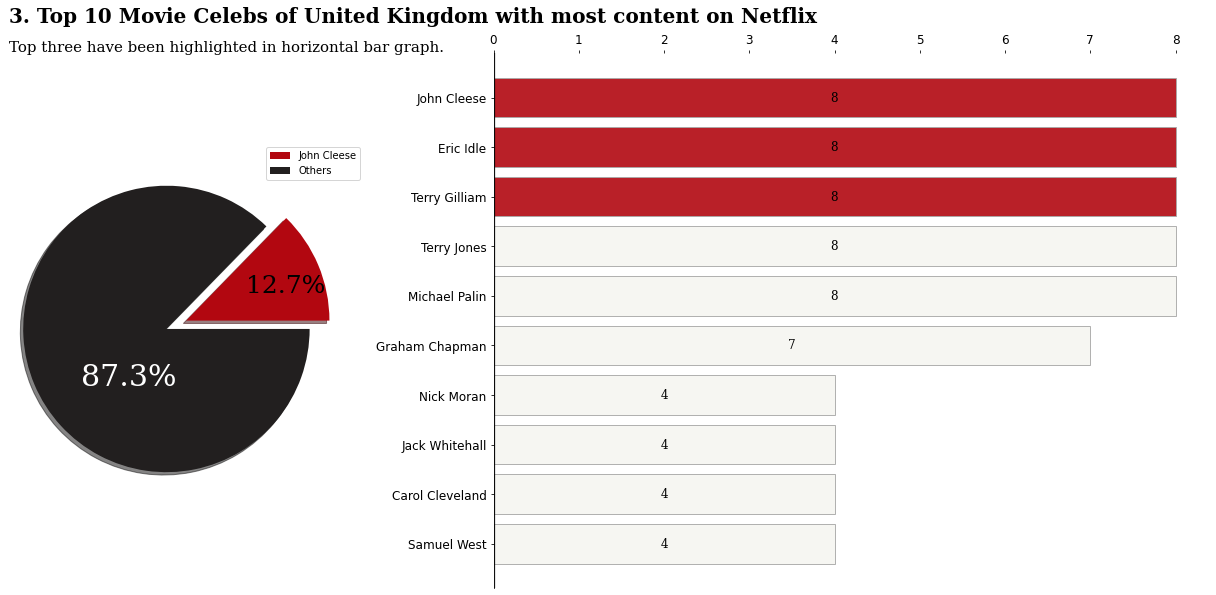

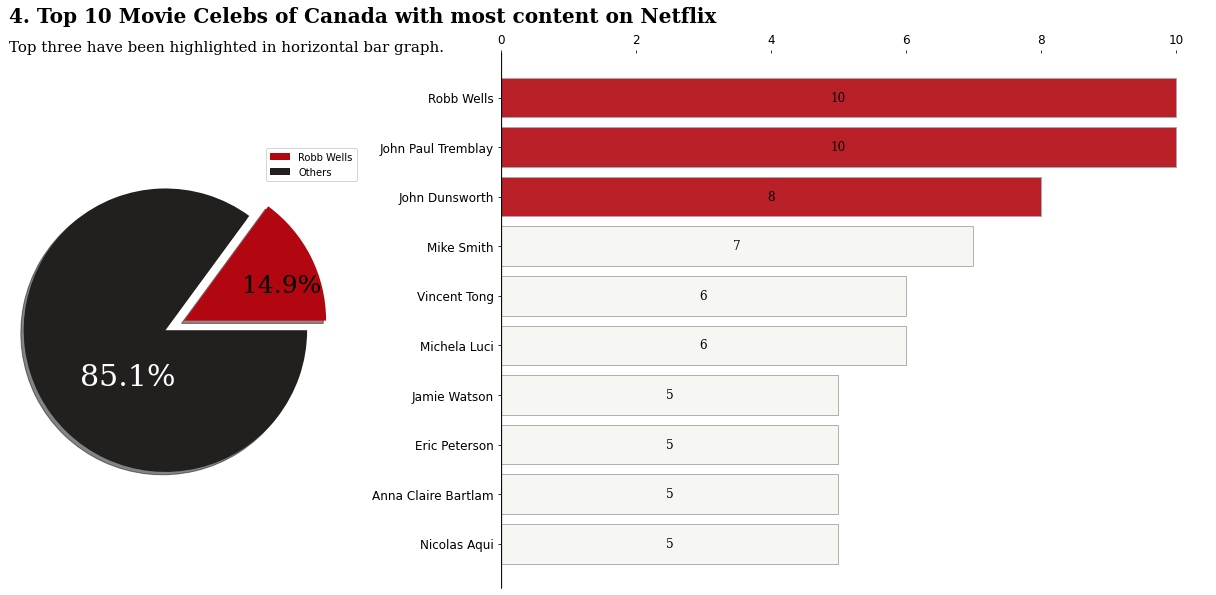

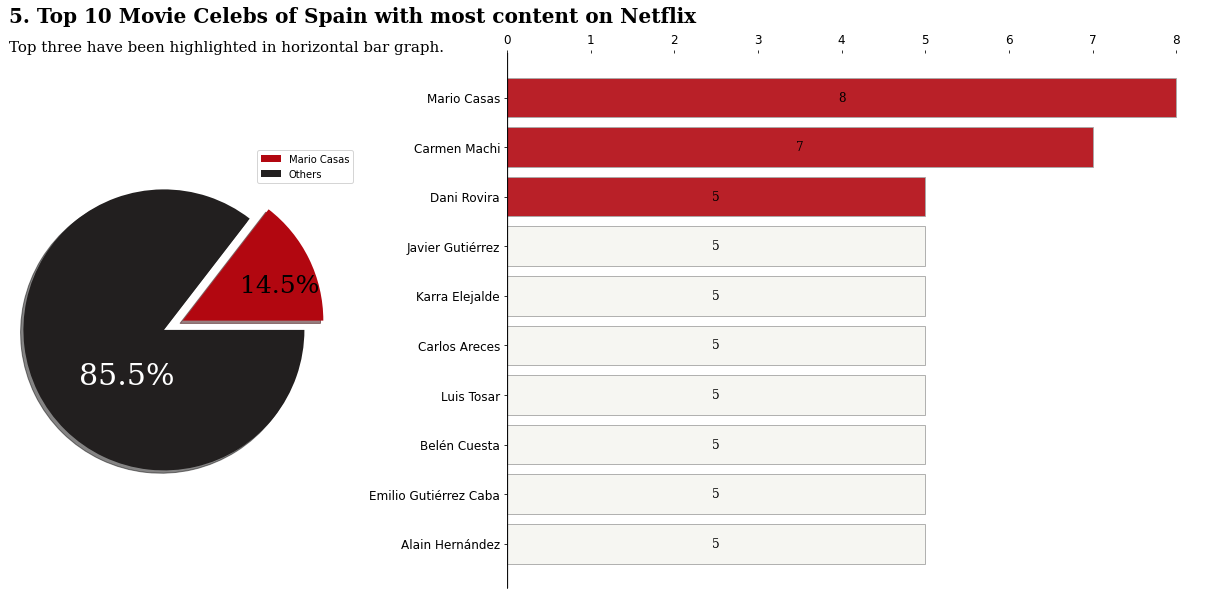

In [61]:
for i in range(5):
    data4 = na_movie_celeb[na_movie_celeb['countries'] == countries_movie[i]].reset_index(drop = True)
    index = i+1
    country = data4['countries'][0]
    
    labels = [data4['celebs'][0], 'Others']
    sizes = [data4['count'][0], sum(data4['count'][1:])]
    explode = (0, 0.15)
    
    # For horizontal bar graph
    color_map1 = ['#f5f5f1' for _ in range(10)]
    color_map1[0] = color_map1[1] = color_map1[2] = '#b20710'
    
    fig, ax = plt.subplots(1,2, figsize = (17,8), gridspec_kw={'width_ratios': [1, 2]})
    
    ## Pie plot
    ax[0].pie(sizes, explode = explode, colors=['#b20710', '#221f1f'], shadow = True)
    ax[0].legend(labels, loc="best")
    
    # Plotting Pie Chart values
    ax[0].annotate(f"{round(sizes[0]/(sizes[0]+sizes[1]) * 100,1)}%", xy=(0.97, 0.2), ha='right',fontsize=25, 
                   fontweight='light', fontfamily='serif', color='black')

    ax[0].annotate(f"{round(sizes[1]/(sizes[0]+sizes[1]) * 100,1)}%", xy=(-0.4, -0.4), va = 'center', ha='center',fontsize=30,
                   fontweight='light', fontfamily='serif', color='white')


    # Removing borders
    for i in ['top', 'left', 'right', 'bottom']:
        ax[0].spines[i].set_visible(False)

    
    # Horizontal Bar Graph

    ax[1].barh(data4['celebs'], data4['count'], color = color_map1, alpha=0.9, edgecolor = 'darkgray')

    for i in data4.index:
        ax[1].annotate(f"{data4['count'][i]}", xy = (data4['count'][i]/2, i), va = 'center', ha = 'center', fontsize=12,
                   fontweight = 'light', fontfamily = 'serif')

    # Removing borders from plot
    for i in ['top', 'bottom', 'right']:
        ax[1].spines[i].set_visible(False)

    # Title and Subtitle
    fig.text(0.01, 1, '{}. Top 10 Movie Celebs of {} with most content on Netflix'.format(index, country), fontsize=20, 
             fontweight='bold', fontfamily='serif')
    fig.text(0.01, 0.95, 'Top three have been highlighted in horizontal bar graph.', fontsize=15, fontweight='light', 
             fontfamily='serif')    

    # thickening the side line and inverting the axis
    plt.axvline(x = 0, color = 'black', linewidth = 1.3, alpha = .7)
    ax[1].tick_params(axis='both', which='major', labelsize=12)
    ax[1].xaxis.tick_top()
    ax[1].invert_yaxis()

    plt.tight_layout()
    plt.show()
    print('\n')
    print('\n')

In [62]:
tv_ten = []
countries_tv = list(tv['country'].value_counts()[:5].index)

for countries, c in zip(countries_tv, ['\033[36m', '\033[92m', '\033[93m', '\033[91m', '\033[94m']):
    tmp = tv[tv['country'] == countries].copy()
    tmp = tmp.reset_index(drop=True)
    actors= []
    for i in range(len(tmp)):
        if tmp.loc[i,'cast'] =='No Cast Specified' or type(tmp.loc[i,'cast']) !=str:
            continue
        elif "," not in tmp.loc[i,'cast']:
            actors.append(tmp.loc[i,'cast'])
        else:
            for j in tmp.loc[i,'cast'].split(", "):
                actors.append(j)
    print('\033[1m', c, countries, " : ",sorted(Counter(actors).items(), key= lambda x :x[1],reverse=True)[0], '\033[0m')
    tv_ten.append(sorted(Counter(actors).items(), key= lambda x :x[1],reverse=True)[:10])

  United States  :  ('Kevin Michael Richardson', 9) 
  United Kingdom  :  ('David Attenborough', 7) 
  Japan  :  ('Takahiro Sakurai', 22) 
  South Korea  :  ('Kim Won-hae', 5) 
  India  :  ('Rajesh Kava', 3) 


In [63]:
tv_celeb = []
for i in range(5):
    country = countries_tv[i]
    for j in range(10):
        celebs, count = tv_ten[i][j]
        tv_celeb.append([country, celebs, count])
        
na_tv_celeb = pd.DataFrame(tv_celeb, columns = ['countries', 'celebs', 'count'])

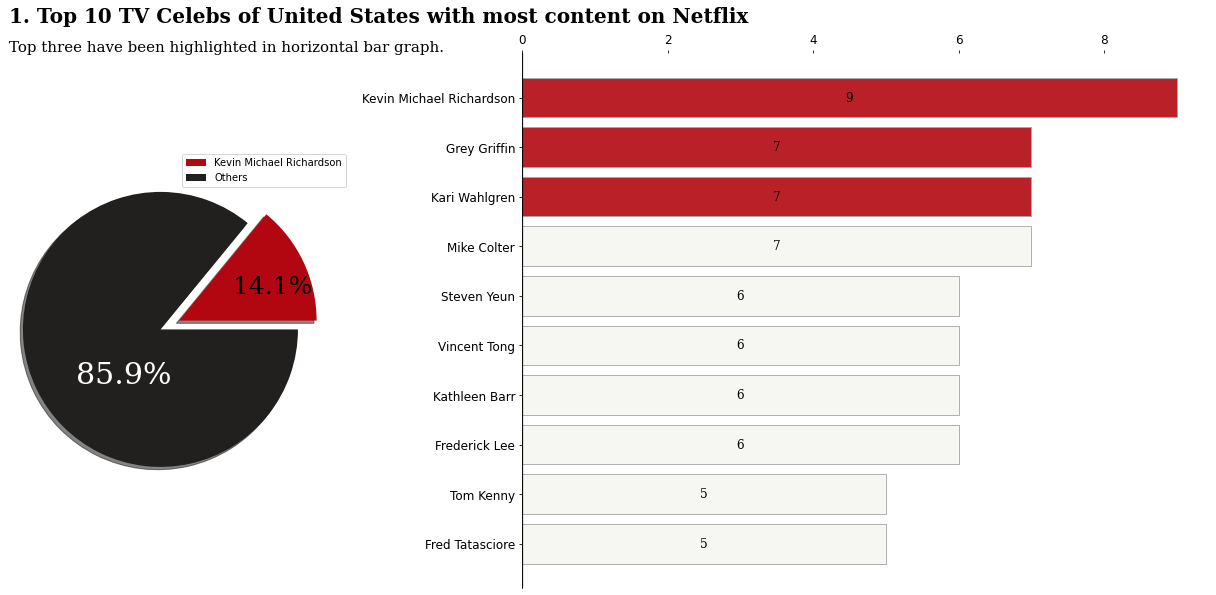

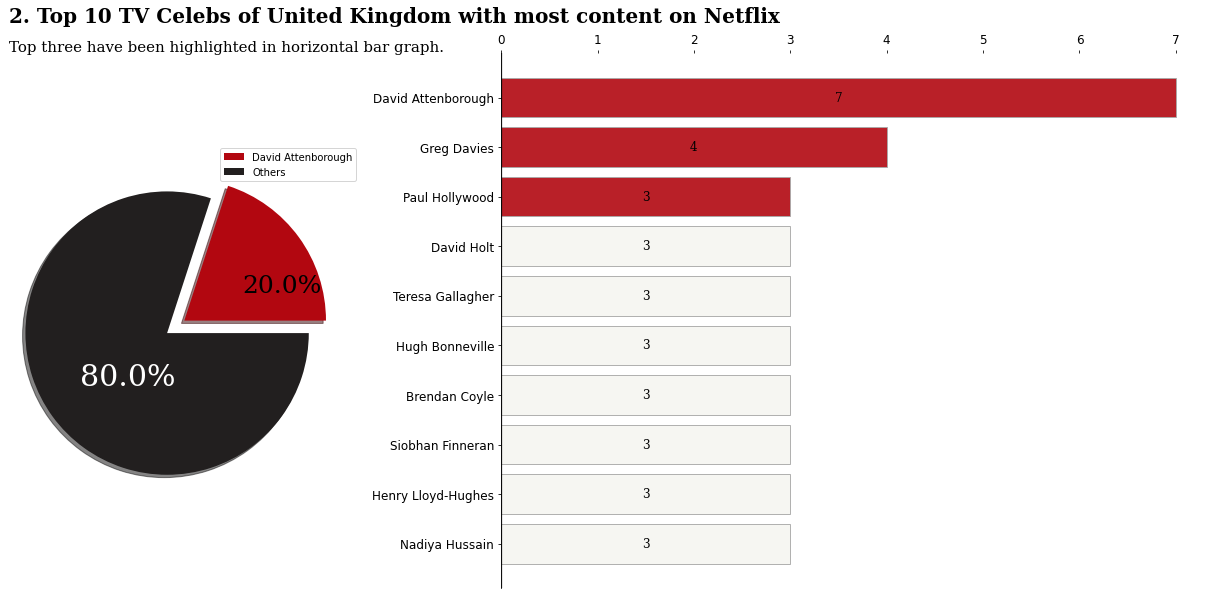

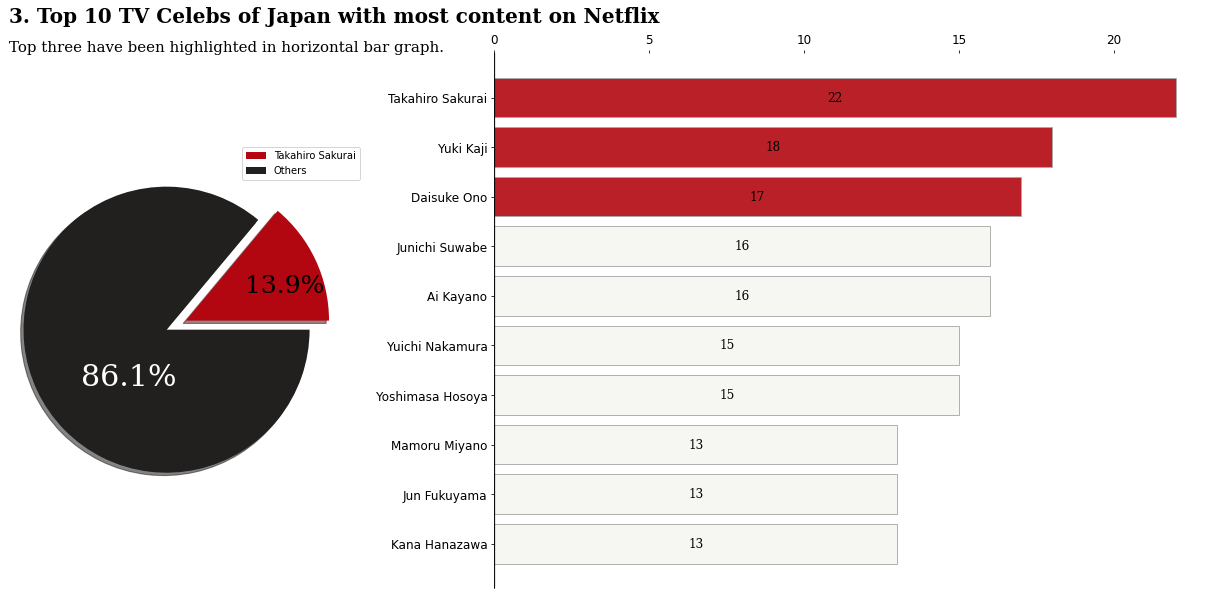

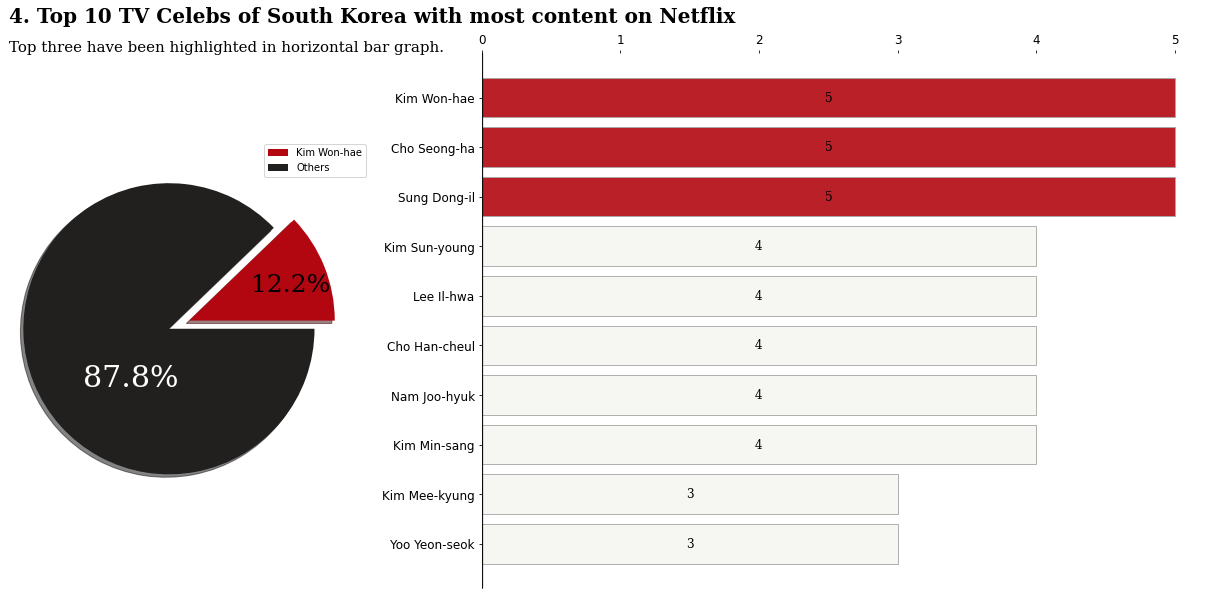

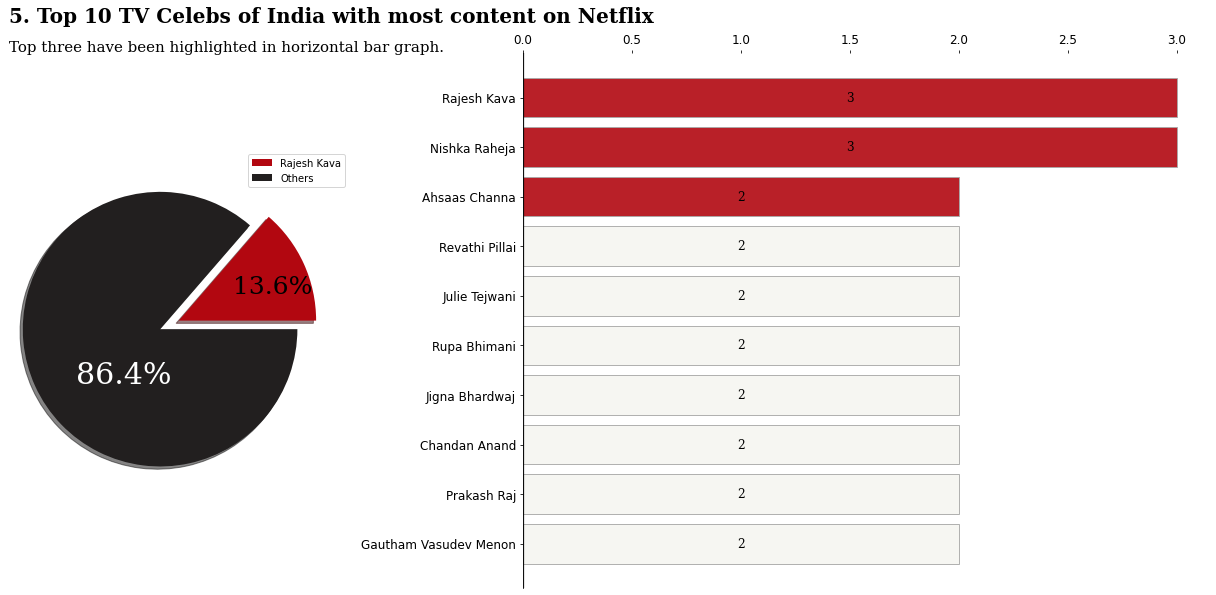

In [64]:
for i in range(5):
    data4 = na_tv_celeb[na_tv_celeb['countries'] == countries_tv[i]].reset_index(drop = True)
    index = i+1
    country = data4['countries'][0]
    
    labels = [data4['celebs'][0], 'Others']
    sizes = [data4['count'][0], sum(data4['count'][1:])]
    explode = (0, 0.15)
    
    # For horizontal bar graph
    color_map1 = ['#f5f5f1' for _ in range(10)]
    color_map1[0] = color_map1[1] = color_map1[2] = '#b20710'
    
    fig, ax = plt.subplots(1,2, figsize = (17,8), gridspec_kw={'width_ratios': [1, 2]})
    
    ## Pie plot
    ax[0].pie(sizes, explode = explode, colors=['#b20710', '#221f1f'], shadow = True)
    ax[0].legend(labels, loc="best")
    
    # Plotting Pie Chart values
    ax[0].annotate(f"{round(sizes[0]/(sizes[0]+sizes[1]) * 100,1)}%", xy=(0.97, 0.2), ha='right',fontsize=25, 
                   fontweight='light', fontfamily='serif', color='black')

    ax[0].annotate(f"{round(sizes[1]/(sizes[0]+sizes[1]) * 100,1)}%", xy=(-0.4, -0.4), va = 'center', ha='center',fontsize=30,
                   fontweight='light', fontfamily='serif', color='white')


    # Removing borders
    for i in ['top', 'left', 'right', 'bottom']:
        ax[0].spines[i].set_visible(False)

    
    # Horizontal Bar Graph

    ax[1].barh(data4['celebs'], data4['count'], color = color_map1, alpha=0.9, edgecolor = 'darkgray')

    for i in data4.index:
        ax[1].annotate(f"{data4['count'][i]}", xy = (data4['count'][i]/2, i), va = 'center', ha = 'center', fontsize=12,
                   fontweight = 'light', fontfamily = 'serif')

    # Removing borders from plot
    for i in ['top', 'bottom', 'right']:
        ax[1].spines[i].set_visible(False)

    # Title and Subtitle
    fig.text(0.01, 1, '{}. Top 10 TV Celebs of {} with most content on Netflix'.format(index, country), fontsize=20, 
             fontweight='bold', fontfamily='serif')
    fig.text(0.01, 0.95, 'Top three have been highlighted in horizontal bar graph.', fontsize=15, fontweight='light', 
             fontfamily='serif')    

    # thickening the side line and inverting the axis
    plt.axvline(x = 0, color = 'black', linewidth = 1.3, alpha = .7)
    ax[1].tick_params(axis='both', which='major', labelsize=12)
    ax[1].xaxis.tick_top()
    ax[1].invert_yaxis()

    plt.tight_layout()
    plt.show()
    print('\n')
    print('\n')

In the United States, even though **Samuel L. Jackson** has the most content overall, it changes when it comes to movie celebs, as **Adam Sandler** has more when it comes to movies.

Overall, the ranking of each country’s celebs remains unchanged. Some celebs have done tv shows, which makes their ranks increase or decrease based on the list.

## Genre

Let's have a look at a WordCloud to get a review of it

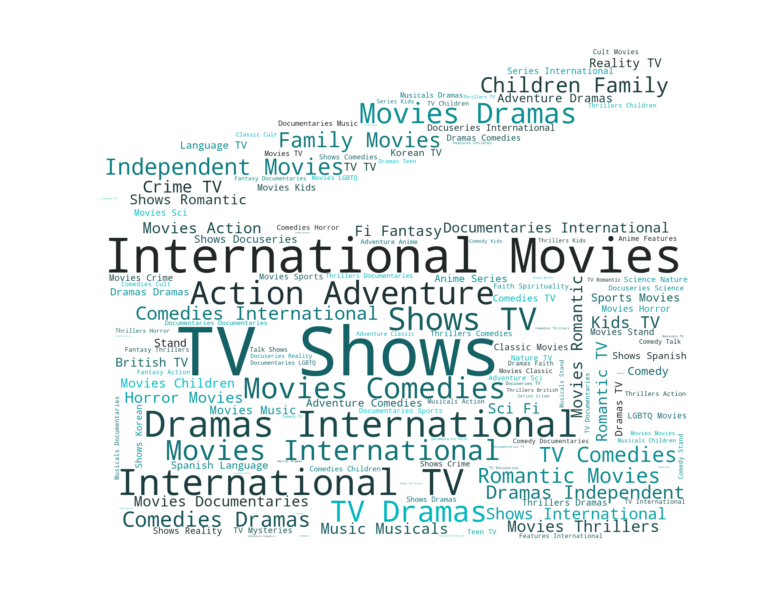

In [65]:
# Custom colour map based on Genre
cmap = cls.LinearSegmentedColormap.from_list("", ['#221f1f', '#00C5CD'])

text = str(list(df['genre'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')

mask = np.array(Image.open('Genre-logo.png'))
                                                  
word = WordCloud(background_color = 'white', width = 500,  height = 200,colormap=cmap, max_words = 200, 
                 mask = mask).generate(text)

plt.figure(figsize=[12,8])
plt.imshow(word, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Since each title is a part of two or more genres, we will create a heatmap to find the correlation between each genre.

In [66]:
# Custom colour map
cmap = cls.LinearSegmentedColormap.from_list('', ['#221f1f', '#00C5CD','#f5f5f1'])

# Function for 'Genre Heatmap'
def heatmap(df, title):
    Types = []
    for i in df['genre']: Types += i
    Types = set(Types)
    print('\033[1m' + 'Netflix {} Dataset comprises {} types of genre categories'.format(title, len(Types)) + '\033[0m')    
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns = mlb.classes_, index = test.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize = (14, 10))
    fig.text(.50,.88,'{} Genre correlation'.format(title), fontfamily='serif',fontweight='bold',fontsize=15)
    pl = sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, vmin = -.3, center=0, square=True, linewidths=2.5)
    
    plt.show()

Netflix Movie Dataset comprises 20 types of genre categories


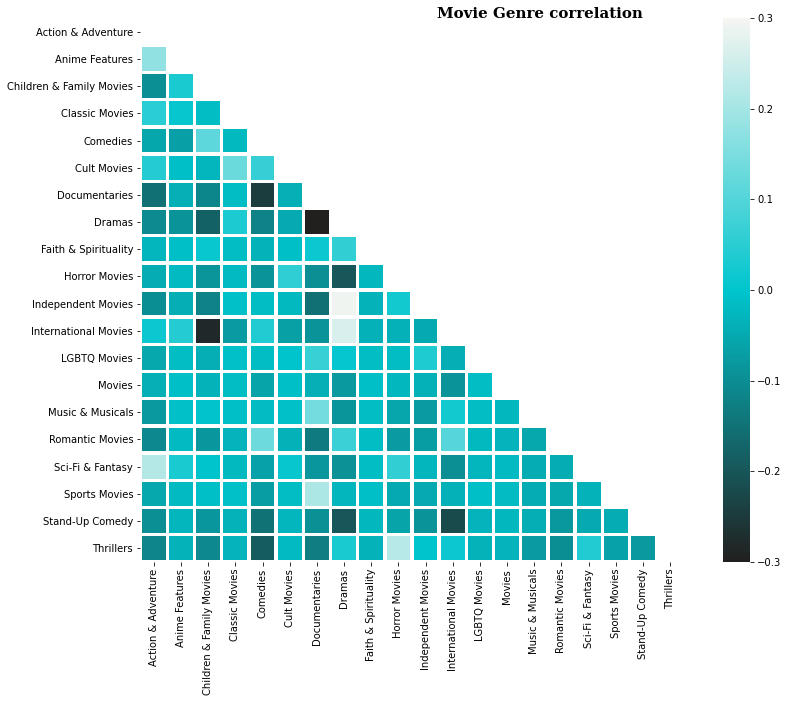

In [67]:
# Genre Heatmap of Movies
heatmap(movies, 'Movie')
plt.show()

It is interesting to see that most titles with **Documentaries** tags also have **Dramas** with them.

On the other hand, most titles with **International Movies** also have **Children & Family Movies**.

Netflix TV Shows Dataset comprises 22 types of genre categories


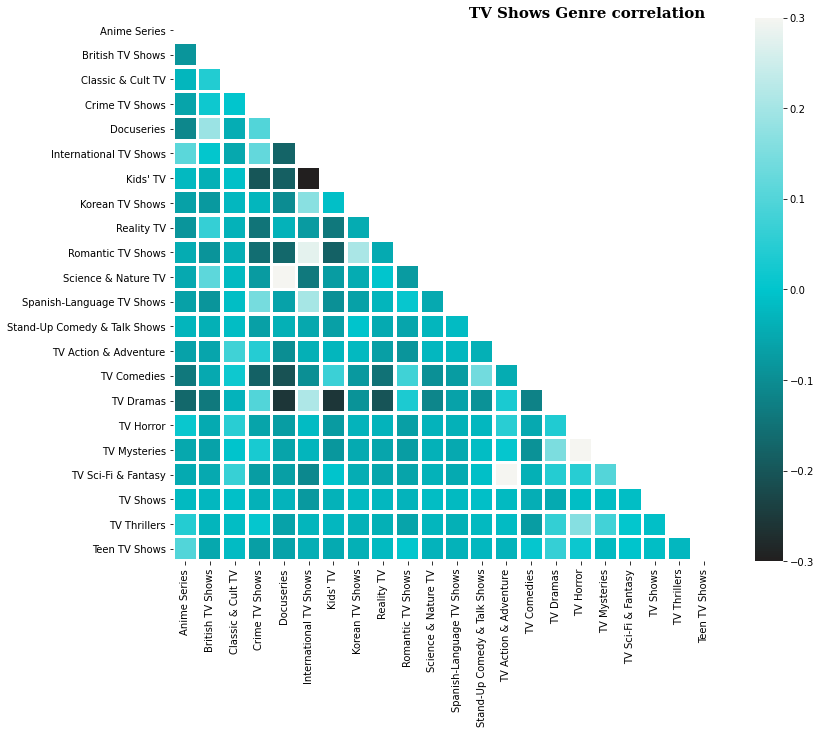

In [68]:
# Genre Heatmap of TV Shows
heatmap(tv, 'TV Shows')
plt.show()

We can see a strong correlation between **Kid's TV** and **International TV Shows**, and **Kid's TV** and **TV Dramas**.

Let's see the top ten genres of Movies and TV Shows.

In [69]:
def top(df, title):
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res1 = pd.DataFrame(mlb.fit_transform(test), columns = mlb.classes_, index = test.index)
    
    genre = []
    for i in res1.columns:
        t = res1[i].sum()
        genre.append([i, t])
    
    df_genre = pd.DataFrame(genre, columns = ['Genre', 'Count']).sort_values(by = 'Count', ascending = False)[:10]
    df_genre.reset_index(inplace = True, drop = True)
    
    # Color and Title
    t,c = ('TV Show', '#221f1f')
    if title == "Movies": t, c = ('Movie', '#00C5CD')     

    fig, ax = plt.subplots(1,1,figsize=(14, 7))

    ax.barh(df_genre['Genre'], df_genre['Count'], color='#f5f5f1', alpha=0.9, edgecolor = c, hatch = '\/')

    for i in df_genre.index:
        ax.annotate(f"{df_genre['Count'][i]}", xy = (df_genre['Count'][i] + 55, i), va = 'center', ha = 'center',
                fontweight = 'light', fontfamily = 'serif')

    # Removing borders from plot
    for i in ['top', 'bottom', 'right']:
        ax.spines[i].set_visible(False)

    # Title and Subtitle
    fig.text(0.09, 0.95, 'Top Ten Genres of {}'.format(title), fontsize=15, fontweight='bold', fontfamily='serif')
    fig.text(0.78,.16,"{}".format(t), fontweight="bold", fontfamily='serif', fontsize=15, color=c)
    

    # thickening the side line and inverting the axis
    plt.axvline(x = 0, color = 'black', linewidth = 1.3, alpha = .7)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.tick_top()
    ax.invert_yaxis()

    plt.show()

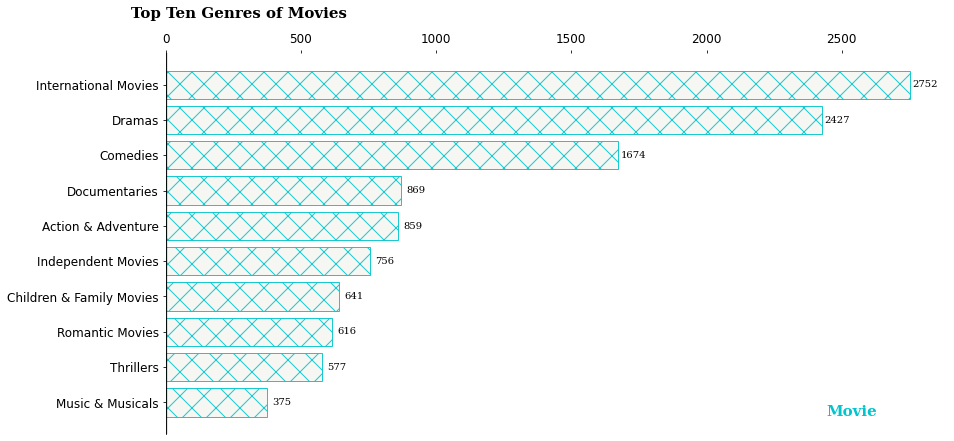

In [70]:
top(movies,'Movies')

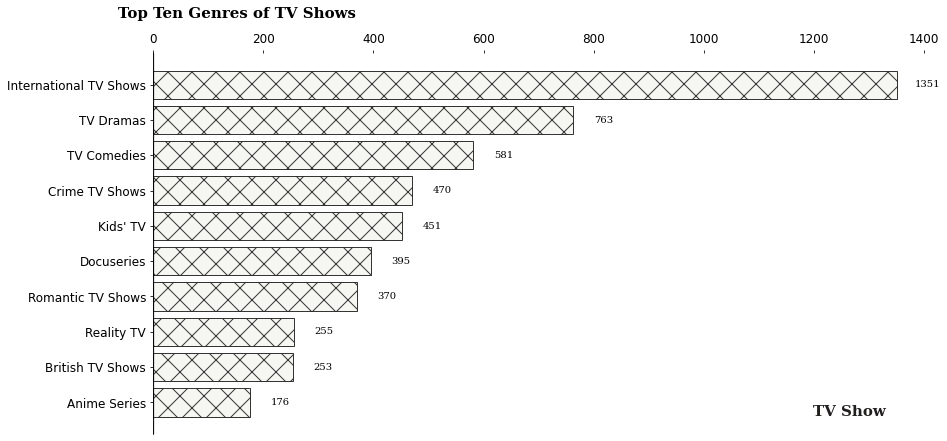

In [71]:
top(tv, 'TV Shows')

We can see **International Movies/TV Shows** have dominated the genre, followed by **Dramas/TV Dramas**.

## Target Ages

Created with the help of a rating column, this feature tells us about the target audience of the Movie/TV Show.

In [72]:
v = df['target_ages'].value_counts()

## Pie plot
fig, ax = plt.subplots(1,1,figsize=(12, 8))
labels = ['Adults', 'Teens', 'Older Kids', 'Kids']
sizes = [v[0], v[1], v[2], v[3] ]
explode = (0.04, 0.05, 0.05, 0.05)
ax.pie(sizes, explode = explode, colors = ['#221f1f','#E5E5E5','#00C5CD','#00868B'], shadow = True)
    
# Annotations
ax.annotate(f"{round(sizes[0]/sum(sizes) * 100,1)}%", xy=(0.40, 0.5), ha='right',fontsize=35, 
                   fontweight='light', fontfamily='serif', color='white')

ax.annotate(f"{labels[0]}", xy=(0.05, 0.3), va = 'center', ha='center',fontsize=20, fontweight='light',fontfamily='serif',
              color = 'white')
    
ax.annotate(f"{round(sizes[1]/sum(sizes) * 100,1)}%", xy=(-0.4, -0.4), va = 'center', ha='center',fontsize=30,
                   fontweight='light', fontfamily='serif', color='black')  

ax.annotate(f"{labels[1]}", xy=(-0.45, -0.6), va = 'center', ha='center',fontsize=18, fontweight='light',fontfamily='serif',
              color = 'black')

ax.annotate(f"{round(sizes[2]/sum(sizes) * 100,1)}%", xy=(0.4, -0.5), va = 'center', ha='center',fontsize=25,
                   fontweight='light', fontfamily='serif', color='black')  

ax.annotate(f"{labels[2]}", xy=(0.4, -0.7), va = 'center', ha='center',fontsize=15, fontweight='light',fontfamily='serif',
              color = 'black')

ax.annotate(f"{round(sizes[3]/sum(sizes) * 100,1)}%", xy=(0.75, -0.1), va = 'center', ha='center',fontsize=20,
                   fontweight='light', fontfamily='serif', color='white')  

ax.annotate(f"{labels[3]}", xy=(0.75, -0.2), va = 'center', ha='center',fontsize=12, fontweight='light',fontfamily='serif',
              color = 'white')

# Removing borders
for i in ['top', 'left', 'right', 'bottom']:
     ax.spines[i].set_visible(False)

# Title
fig.text(0.05, 0.95, 'Content available as per age groups on Netflix', fontsize=20, fontweight='bold', fontfamily='serif')

plt.show()

Almost half of the content is targeted towards Adults, followed by Teens, Older Kids, and Kids telling us about the targeted age group of the platform.

Let's see how Netflix approaches the audience in certain demographies with the help of a heat map.

In [73]:
data5 = df.groupby('primary_country')[['primary_country','count']].sum().sort_values(by='count',
                                                                                     ascending=False).reset_index()[:10]
data5 = data5['primary_country']


data5_heatmap = df.loc[df['primary_country'].isin(data5)]
data5_heatmap = pd.crosstab(data5_heatmap['primary_country'],data5_heatmap['target_ages'],normalize = "index").T

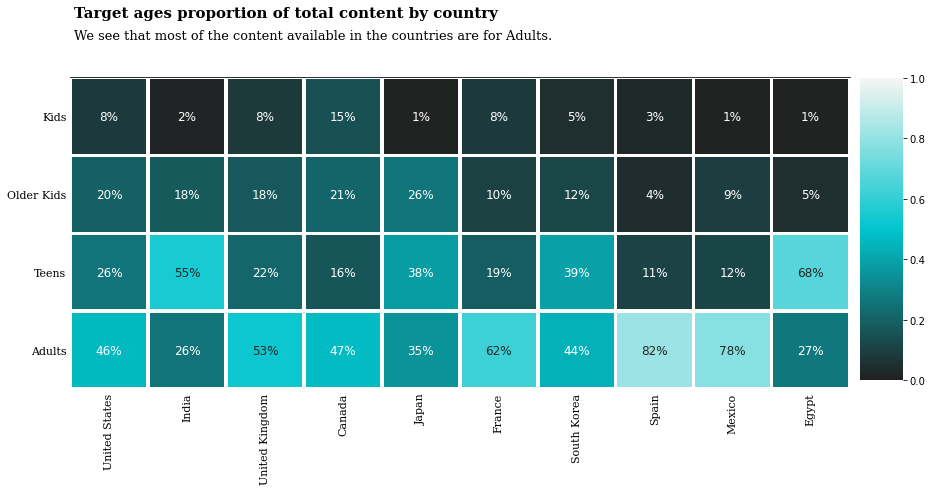

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

age_order = ['Kids','Older Kids','Teens','Adults']

cbar_ax = fig.add_axes([.999, .33, .05, .35])
sns.heatmap(data5_heatmap.loc[age_order, data5],cmap = cmap, square = True, linewidth = 2.5, cbar = True, cbar_ax = cbar_ax,
            annot = True,fmt='1.0%', vmax = 1, vmin = 0, ax = ax, annot_kws = {"fontsize":12})

ax.spines['top'].set_visible(True)


fig.text(.09, .75, 'Target ages proportion of total content by country', fontweight = 'bold', fontfamily = 'serif',
         fontsize = 15, ha = 'left')  
fig.text(.09, .725, 'We see that most of the content available in the countries are for Adults.', fontfamily = 'serif',
         fontsize = 13, ha = 'left')
ax.set_yticklabels(ax.get_yticklabels(), fontfamily = 'serif', rotation = 0, fontsize = 11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily = 'serif', rotation = 90, fontsize = 11)

ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis = u'both', which = u'both', length = 0)
plt.tight_layout()
plt.show()

Here we see interesting differences between countries. Most shows in India and Egypt are targeted at teens, for instance. Whereas, countries like Japan and South Korea have pretty uniform targeted content for Adults, Teens, and Older Kids.

## Director

Let's explore and find the best directors with most content on Netflix.

*(NOTE: This information may not be 100% accurate because of the non-availability of full information for every row.)*

In [75]:
t_director = []
countries_direct = list(df['country'].value_counts()[:10].index)

for countries, c in zip(countries_direct, ['\033[95m', '\033[36m', '\033[94m', '\033[96m', '\033[92m', '\033[93m',
                                          '\033[91m', '\033[95m', '\033[96m', '\033[91m']):
    tmp = df[df['country'] == countries].copy()
    tmp = tmp.reset_index(drop=True)
    direct= []
    for i in range(len(tmp)):
        if tmp.loc[i,'director'] =='No Director Specified' or type(tmp.loc[i,'director']) !=str:
            continue
        elif "," not in tmp.loc[i,'director']:
            direct.append(tmp.loc[i,'director'])
        else:
            for j in tmp.loc[i,'director'].split(", "):
                direct.append(j)
    print('\033[1m',c, countries, " : ",sorted(Counter(direct).items(), key= lambda x :x[1],reverse=True)[0], '\033[0m')
    t_director.append(sorted(Counter(direct).items(), key= lambda x :x[1],reverse=True)[:10])

  United States  :  ('Marcus Raboy', 16) 
  India  :  ('Rajiv Chilaka', 21) 
  United Kingdom  :  ('Edward Cotterill', 4) 
  Japan  :  ('Toshiya Shinohara', 7) 
  South Korea  :  ('Kim Joo-hyung', 2) 
  Canada  :  ('Justin G. Dyck', 7) 
  Spain  :  ('Alexis Morante', 3) 
  France  :  ('Thierry Donard', 5) 
  Egypt  :  ('Youssef Chahine', 7) 
  Mexico  :  ('Jan Suter', 12) 


**Rajiv Chilaka** with 21 Movies/TV Shows from India has the most content available on the platform, even though India is in the second position in the contribution of content.

Let's see the top directors with the most content on the platform of the top ten countries.

In [76]:
directors = []
for i in range(10):
    country = countries_direct[i]
    for j in range(10):
        directs, count = t_director[i][j]
        directors.append([country, directs, count])
        
na_directors = pd.DataFrame(directors, columns = ['countries', 'directors', 'count'])

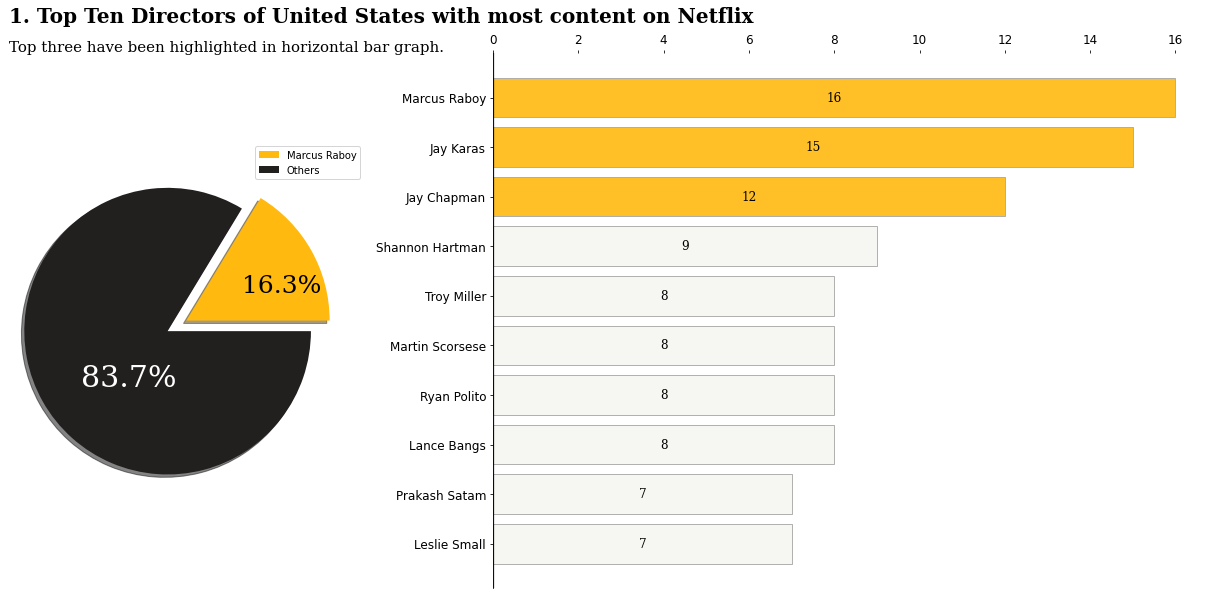

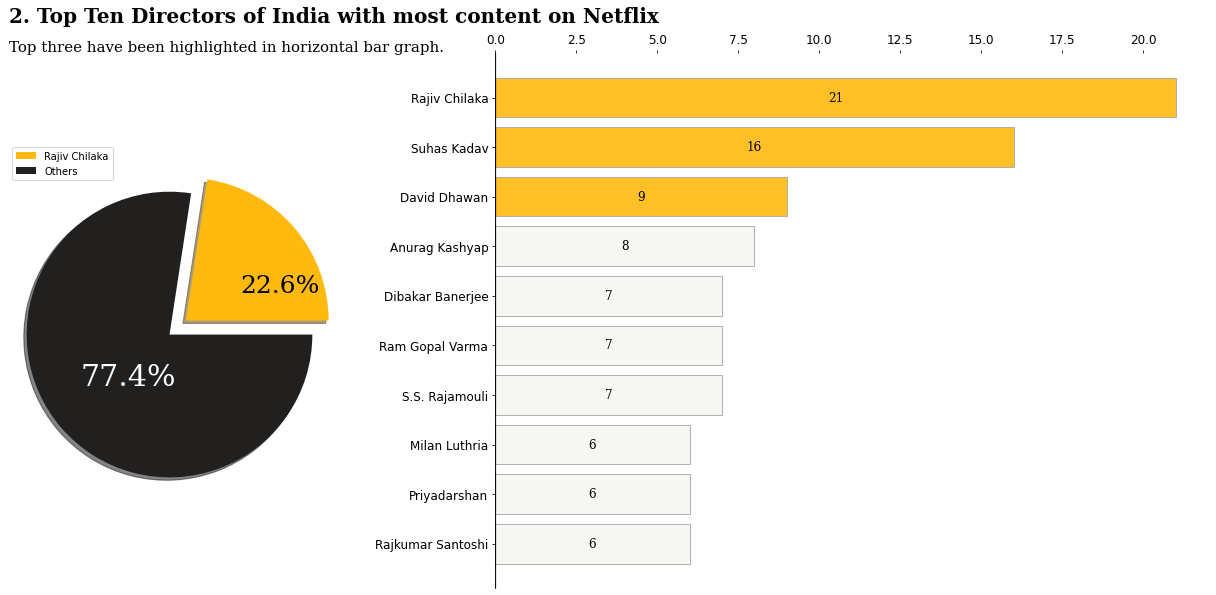

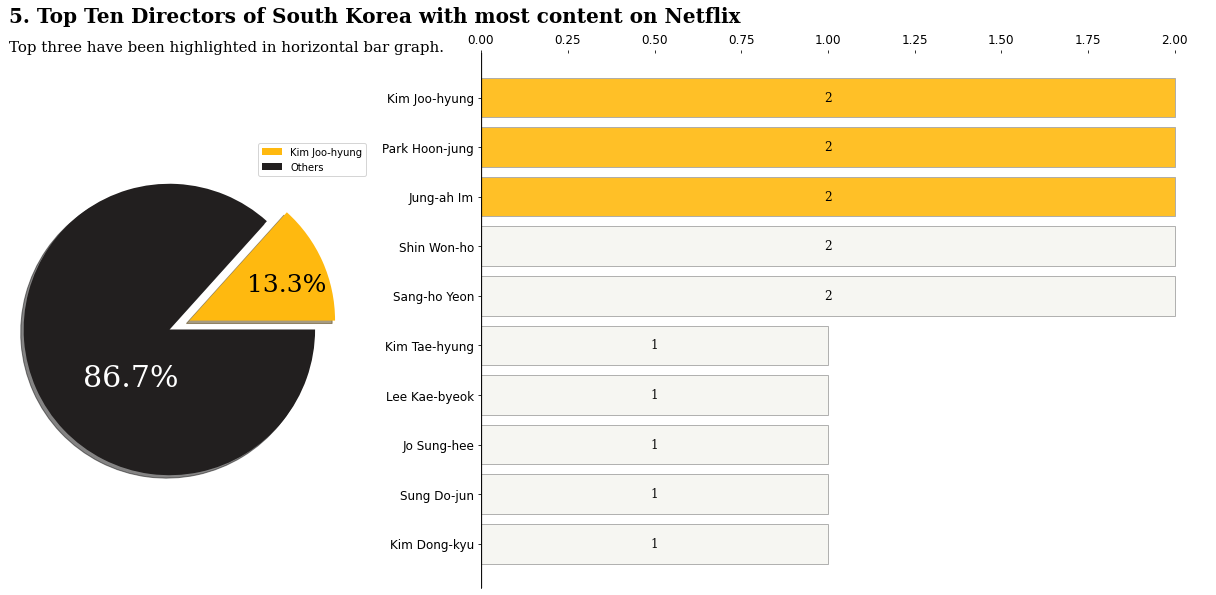

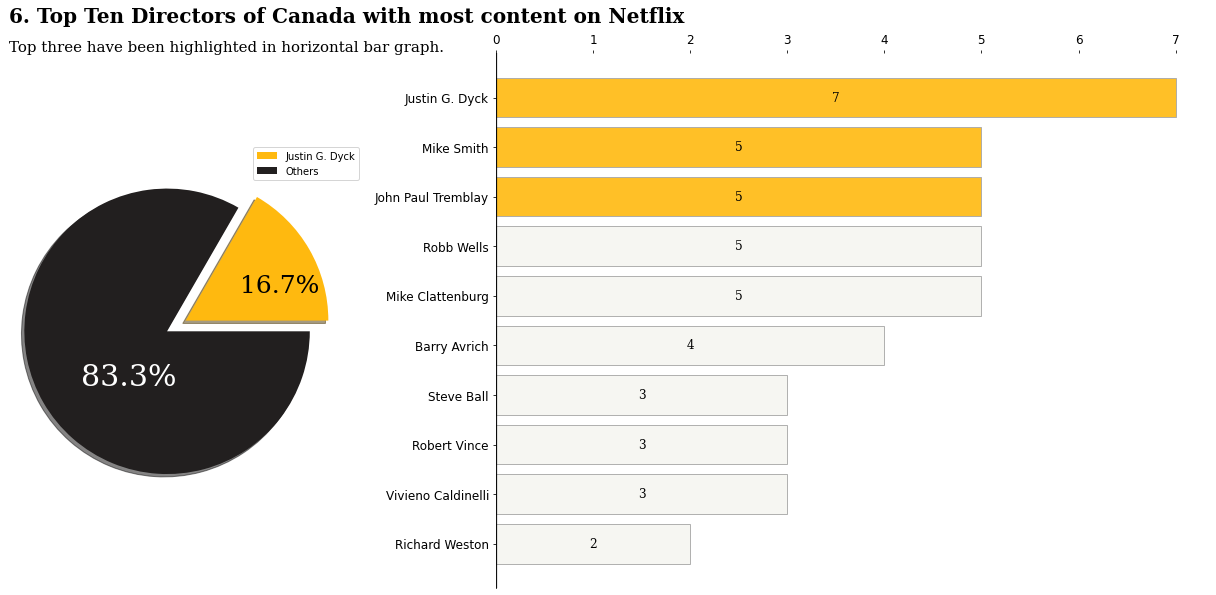

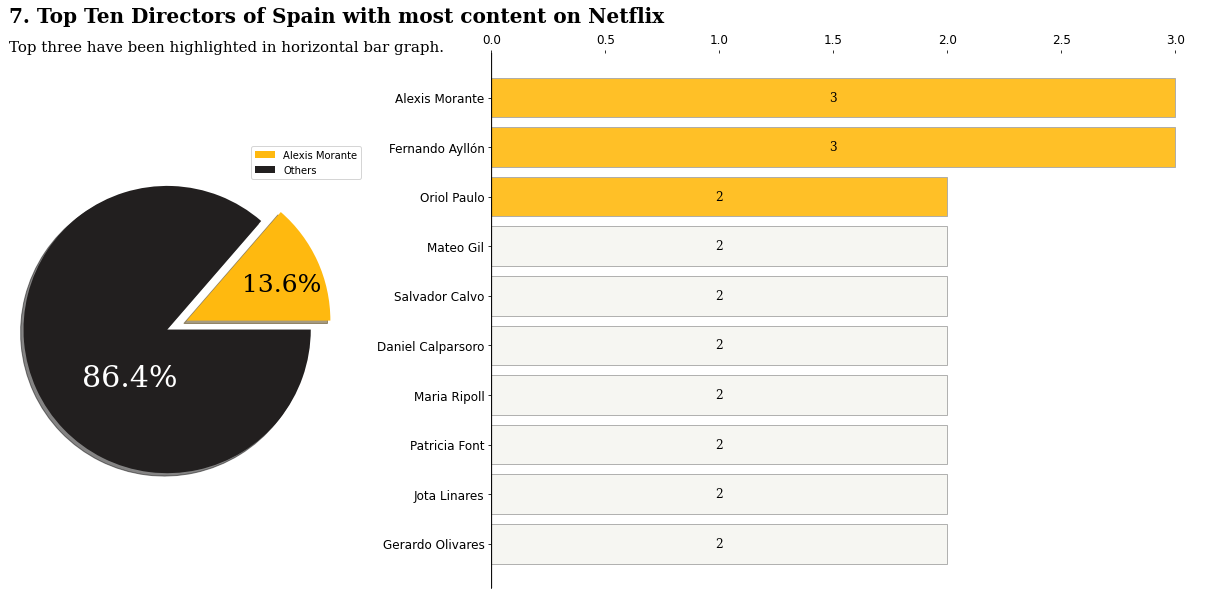

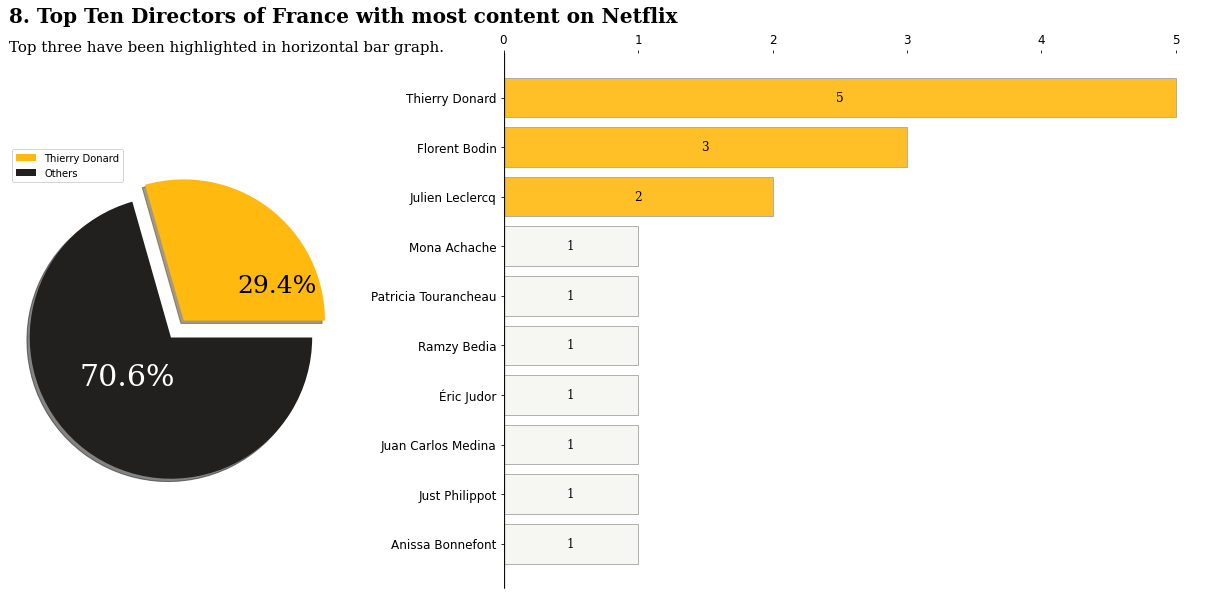

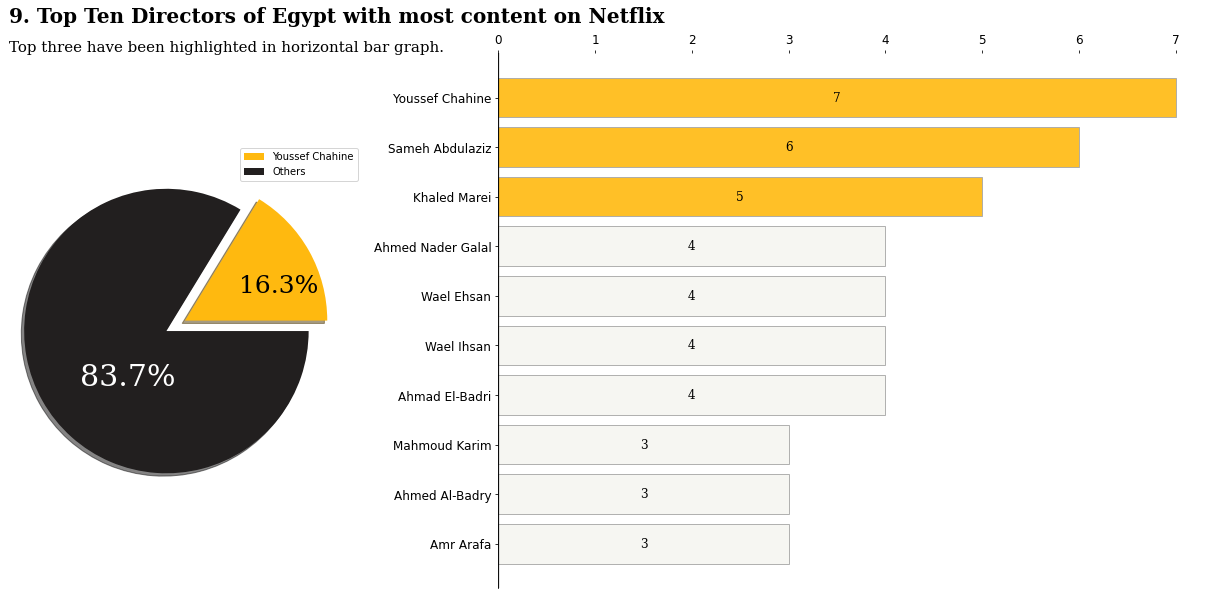

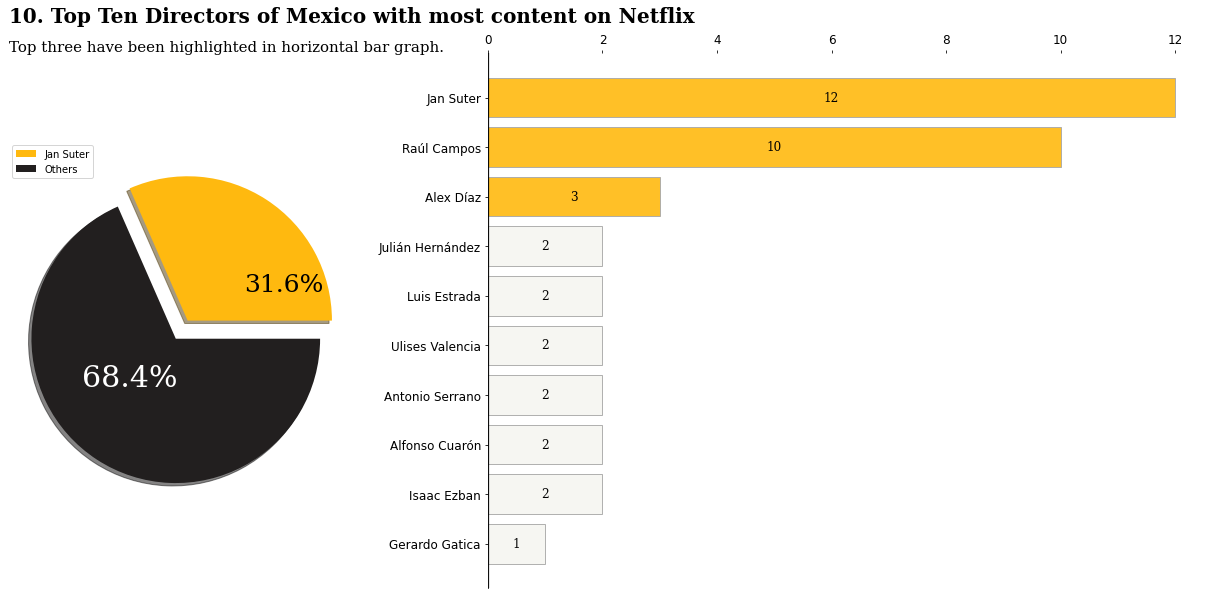

In [77]:
for i in range(10):
    data4 = na_directors[na_directors['countries'] == countries_direct[i]].reset_index(drop = True)
    index = i+1
    country = data4['countries'][0]
    
    labels = [data4['directors'][0], 'Others']
    sizes = [data4['count'][0], sum(data4['count'][1:])]
    explode = (0, 0.15)
    
    # For horizontal bar graph
    color_map1 = ['#f5f5f1' for _ in range(10)]
    color_map1[0] = color_map1[1] = color_map1[2] = '#FFB90F'
    
    fig, ax = plt.subplots(1,2, figsize = (17,8), gridspec_kw={'width_ratios': [1, 2]})
    
    ## Pie plot
    ax[0].pie(sizes, explode = explode, colors=['#FFB90F', '#221f1f'], shadow = True)
    ax[0].legend(labels, loc="best")
    
    # Plotting Pie Chart values
    ax[0].annotate(f"{round(sizes[0]/(sizes[0]+sizes[1]) * 100,1)}%", xy=(0.94, 0.2), ha='right',fontsize=25, 
                   fontweight='light', fontfamily='serif', color='black')

    ax[0].annotate(f"{round(sizes[1]/(sizes[0]+sizes[1]) * 100,1)}%", xy=(-0.4, -0.4), va = 'center', ha='center',fontsize=30,
                   fontweight='light', fontfamily='serif', color='white')


    # Removing borders
    for i in ['top', 'left', 'right', 'bottom']:
        ax[0].spines[i].set_visible(False)

    
    # Horizontal Bar Graph

    ax[1].barh(data4['directors'], data4['count'], color = color_map1, alpha=0.9, edgecolor = 'darkgrey')

    for i in data4.index:
        ax[1].annotate(f"{data4['count'][i]}", xy = (data4['count'][i]/2, i), va = 'center', ha = 'center', fontsize=12,
                   fontweight = 'light', fontfamily = 'serif', color='black')

    # Removing borders from plot
    for i in ['top', 'bottom', 'right']:
        ax[1].spines[i].set_visible(False)

    # Title and Subtitle
    fig.text(0.01, 1, '{}. Top Ten Directors of {} with most content on Netflix'.format(index, country), fontsize=20, 
             fontweight='bold', fontfamily='serif')
    fig.text(0.01, 0.95, 'Top three have been highlighted in horizontal bar graph.', fontsize=15, fontweight='light', 
             fontfamily='serif')    

    # thickening the side line and inverting the axis
    plt.axvline(x = 0, color = 'black', linewidth = 1.3, alpha = .7)
    ax[1].tick_params(axis='both', which='major', labelsize=12)
    ax[1].xaxis.tick_top()
    ax[1].invert_yaxis()

    plt.tight_layout()
    plt.show()
    print('\n')
    print('\n')

Except for India and Mexico where **Rajiv Chilaka** (21) and **Jan Suter** (12) are dominating their respective markets, there is no other country where a specific director's contents is more in quantity on Netflix.

## Description

We are concluding our Exploratory Data Analysis with a WordCloud, made with the help of the description column.

In [78]:
# Custom colour map based on Netflix palette
cmap = cls.LinearSegmentedColormap.from_list("", ['#221f1f', '#CD950C'])

text = str(list(df['description'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')

mask = np.array(Image.open('Netflix-logo.png'))
                                                  
word = WordCloud(background_color = 'white', width = 500,  height = 200,colormap=cmap, max_words = 150, 
                 mask = mask).generate(text)

plt.figure(figsize=[12,12])
plt.imshow(word, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [79]:
def word_map(col):
    # Deciding color for the wordcloud
    pal, data = ('#9C661F', rec)
    if col == 'metadata_soup': pal, data = ('#b20710', filters)
    
    # Custom colour map based on Netflix palette
    cmap = cls.LinearSegmentedColormap.from_list("", ['#221f1f', pal])
    
    text = str(list(data[col])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')
    
    mask = np.array(Image.open('Netflix-N-logo.png'))
    
    word = WordCloud(background_color = 'white', width = 500,  height = 200,colormap=cmap, max_words = 150, 
                 mask = mask).generate(text)
    
    plt.figure(figsize=[10,10])
    plt.imshow(word, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# Recommendation System

Recommendation systems are systems that are designed to recommend things to the user based on many factors. These systems predict the most likely products that the users are most likely to purchase and are of interest to them.

There are four types of recommendation systems in general:

* Popularity-Based Recommendation System
* Classification Model
* Content-Based Recommendation System
* Collaborative Filtering

For this case study, we will be creating a content-based recommendation system that will take the content's information (cast, description, director, genre, etc.) present in the Netflix dataset to find a similarity score between the contents to create the recommendation system. The content that is most likely to be similar will be recommended with the help of this score.



## Plot Based Recommender (Description column)

We will calculate similarity scores for all content based on their plot descriptions and recommend movies/TV shows based on that similarity score. The Dataset description feature provides plot descriptions.

In [80]:
rec['description'].head()

0    As her father nears the end of his life, filmm...
1    After crossing paths at a party, a Cape Town t...
2    To protect his family from a powerful drug lor...
3    Feuds, flirtations and toilet talk go down amo...
4    In a city of coaching centers known to train I...
Name: description, dtype: object

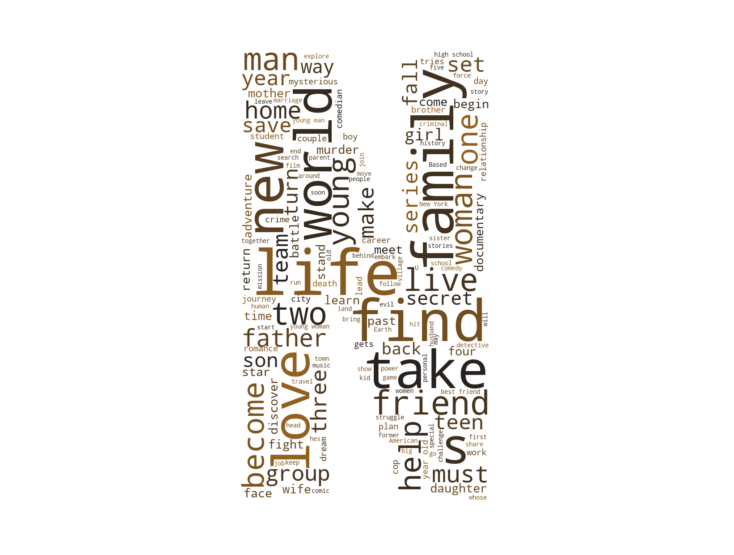

In [81]:
# Visualization of 'description' column for better understanding using WordCloud
word_map('description')

The word vectors of each overview need to be converted. For each description, we will compute the **TF-IDF (Term Frequency-Inverse Document Frequency)** vector. **Term Frequency (TF)** indicates the relative frequency of a word in a document and is calculated as (term instances/total instances). **Inverse Document Frequency (IDF)** is the relative count of documents containing the term given as a log (number of documents/documents with the term). Each word's overall importance to the documents in which it appears equals **TF * IDF**. By doing this, we reduce the significance of words that occur frequently in plot overviews and, therefore, their significance in computing the **similarity score**.

In [82]:
# Defining a TF-IDF Vectorizer Object and removing all english stop words such as 'a', 'an', 'the', etc.
tfidf = TfidfVectorizer(stop_words = 'english')

In [83]:
# Creating the required TF-IDF matrix by fitting and transforming the data
matrix = tfidf.fit_transform(rec['description'])

# Shape of matrix
print('-'*50)
print('\033[1m','Shape of the matrix dataset: {}'. format(matrix.shape), '\033[0m')
print('-'*50)

--------------------------------------------------
 Shape of the matrix dataset: (8807, 18895) 
--------------------------------------------------


This shape of the matrix means that **8,807** content in our dataset is being described by **18,895** different words. Using this matrix, we can calculate a **similarity score**. There are several methods for this; such as the Euclidean, Pearson, and cosine similarity scores. It is not possible to determine which score is the best. Different scores work well in different schema.

For our recommender, we will be using **cosine similarity** to calculate a numeric quantity that denotes the similarity between
two content. We are using the cosine similarity score since it is independent of magnitude and is relatively easy and fast to
calculate.

$$Similarity(X,Y) = X.Y / |X| * |Y|$$ 

Since we have used the **TF-IDF vectorizer**, calculating the dot product will directly give us cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** rather than **cosine_similarities()** because it is quicker.

In [84]:
# Computing the cosine similarity matrix
sim = linear_kernel(matrix, matrix)

We need a mechanism to identify the index of content in our metadata DataFrame. For that, we will be using the **Title** column after dropping duplicates.

In [85]:
#Constructing a reverse map of indices with the help of title column
indices = pd.Series(rec.index, index = df['title']).drop_duplicates()

Let's define a function that takes in a title as an input and outputs a list of the 10 most similar content along with the name of **Directors**, **Cast**, **Genre**, **Rating**, **Duration**, and **Description**.

In [86]:
def des_recommend(title, sim = sim):
    ids = indices[title]

    # Getting the pairwsie similarity scores of all contents with the title
    sim_scores = list(enumerate(sim[ids]))

    # Sorting the contents based on the similarity scores
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)

    # Getting the scores of the 10 most similar contents
    sim_scores = sim_scores[1:11]            # Starting with 1 as 0 is the title itself

    # Getting the content indices
    content_index = [i[0] for i in sim_scores]
    
    # Features to be shown
    features=['title', 'director','cast', 'genre', 'rating', 'duration', 'description']

    # Return the top 10 most similar movies
    return rec[features].iloc[content_index].reset_index(drop = True)

In [87]:
# Calling the function
des_recommend('NCIS')

title                     director  \
0                             Olympus Has Fallen                Antoine Fuqua   
1                                 ¡Ay, mi madre!                  Frank Ariza   
2                                     Figaro Pho              Luke Jurevicius   
3                          S.W.A.T.: Under Siege                  Tony Giglio   
4                Incredibles 2 (Spanish Version)                    Brad Bird   
5                              The Incredibles 2                    Brad Bird   
6               Dark Chocolate (Bengali Version)           Agnidev Chatterjee   
7                                         Paskal                   Adrian Teh   
8                                     Undefeated  Daniel Lindsay, T.J. Martin   
9  Under Suspicion: Uncovering the Wesphael Case                Alain Brunard   

                                                cast  \
0  Gerard Butler, Aaron Eckhart, Morgan Freeman, ...   
1  Estefanía de los Santos, Secun de la Rosa, Ter...   
2                                    Luke Jurevicius   
3  Sam Jaeger, Michael Jai White, Adrianne Palick...   
4  Víctor Trujillo, Consuelo Duval, Darío T. Pie,...   
5  Craig T. Nelson, Holly Hunter, Samuel L. Jacks...   
6  Riya Sen, Mahima Chaudhry, Rajesh Sharma, Indr...   
7  Hairul Azreen, Ammar Alfian, Jasmine Suraya, H...   
8  Montrail 'Money' Brown, O.C. Brown, Bill Court...   
9                                  No Cast Specified   

                                               genre rating  duration  \
0                                 Action & Adventure      R       119   
1                     Comedies, International Movies  TV-MA        81   
2                 Children & Family Movies, Comedies  TV-Y7        29   
3           Action & Adventure, International Movies      R        89   
4                 Children & Family Movies, Comedies     PG       118   
5                 Children & Family Movies, Comedies     PG       118   
6            Dramas, International Movies, Thrillers  TV-MA        91   
7   Action & Adventure, Dramas, International Movies  TV-14       115   
8                       Documentaries, Sports Movies  PG-13       113   
9  Crime TV Shows, Docuseries, International TV S...  TV-14         1   

                                         description  
0  A disgraced Secret Service agent must come to ...  
1  When her estranged mother suddenly dies, a wom...  
2  Quirky little Figaro has a whole alphabet's wo...  
3  When a S.W.A.T. team takes in a mysterious, hi...  
4  When Elastigirl gets recruited for a high-prof...  
5  When Elastigirl gets recruited for a high-prof...  
6  In this Bangla thriller inspired by a true sto...  
7  Naval unit PASKAL is among the most elite spec...  
8  An inspirational profile of an inner-city high...  
9  This docuseries follows the high-profile case ...

Since this is completely a **plot-based (Description) recommender**, we may see it is not so accurate. Therefore, we will be trying to add more metrics to improve our model performance.


## Content (Genre, Cast, Director, and Description) based Recommender [Multiple Matrix]

This time we will calculate similarity scores for all content using **Genre**, **Cast**, **Director**, and **Description** columns, and will recommend the top ten similar contents based on that similarity score.

In [88]:
# Selecting the features for fitting
features=['genre', 'director','cast','description','title']
filters = rec[features]

Defining a function to clean the data by removing spaces and making all the words in lowercase.

In [89]:
#Cleaning data by removing spaces and making all the words in lowercase.
def clean(x):
        return str.lower(x.replace(" ", ""))

In [90]:
for feature in features:
    filters[feature] = filters[feature].apply(clean)
    
filters.head()

genre             director  \
0                                      documentaries       kirstenjohnson   
1          internationaltvshows,tvdramas,tvmysteries  nodirectorspecified   
2  crimetvshows,internationaltvshows,tvaction&adv...       julienleclercq   
3                               docuseries,realitytv  nodirectorspecified   
4    internationaltvshows,romantictvshows,tvcomedies  nodirectorspecified   

                                                cast  \
0                                    nocastspecified   
1  amaqamata,khosingema,gailmabalane,thabangmolab...   
2  samibouajila,tracygotoas,samueljouy,nabihaakka...   
3                                    nocastspecified   
4  mayurmore,jitendrakumar,ranjanraj,alamkhan,ahs...   

                                         description                title  
0  asherfathernearstheendofhislife,filmmakerkirst...    dickjohnsonisdead  
1  aftercrossingpathsataparty,acapetownteensetsou...          blood&water  
2  toprotecthisfamilyfromapowerfuldruglord,skille...            ganglands  
3  feuds,flirtationsandtoilettalkgodownamongthein...  jailbirdsneworleans  
4  inacityofcoachingcentersknowntotrainindia’sfin...          kotafactory

In the next step, we will be creating a new column as **'metadata_soup'** which will contain all the metadata from the columns that we want to feed to our vectorizer.

In [91]:
def soup(x):
    return x['director'] +' '+x['cast'] +' '+x['genre'] +' '+x['description']

In [92]:
filters['metadata_soup'] = filters.apply(soup, axis=1)

In [93]:
filters.head()

genre             director  \
0                                      documentaries       kirstenjohnson   
1          internationaltvshows,tvdramas,tvmysteries  nodirectorspecified   
2  crimetvshows,internationaltvshows,tvaction&adv...       julienleclercq   
3                               docuseries,realitytv  nodirectorspecified   
4    internationaltvshows,romantictvshows,tvcomedies  nodirectorspecified   

                                                cast  \
0                                    nocastspecified   
1  amaqamata,khosingema,gailmabalane,thabangmolab...   
2  samibouajila,tracygotoas,samueljouy,nabihaakka...   
3                                    nocastspecified   
4  mayurmore,jitendrakumar,ranjanraj,alamkhan,ahs...   

                                         description                title  \
0  asherfathernearstheendofhislife,filmmakerkirst...    dickjohnsonisdead   
1  aftercrossingpathsataparty,acapetownteensetsou...          blood&water   
2  toprotecthisfamilyfromapowerfuldruglord,skille...            ganglands   
3  feuds,flirtationsandtoilettalkgodownamongthein...  jailbirdsneworleans   
4  inacityofcoachingcentersknowntotrainindia’sfin...          kotafactory   

                                       metadata_soup  
0  kirstenjohnson nocastspecified documentaries a...  
1  nodirectorspecified amaqamata,khosingema,gailm...  
2  julienleclercq samibouajila,tracygotoas,samuel...  
3  nodirectorspecified nocastspecified docuseries...  
4  nodirectorspecified mayurmore,jitendrakumar,ra...

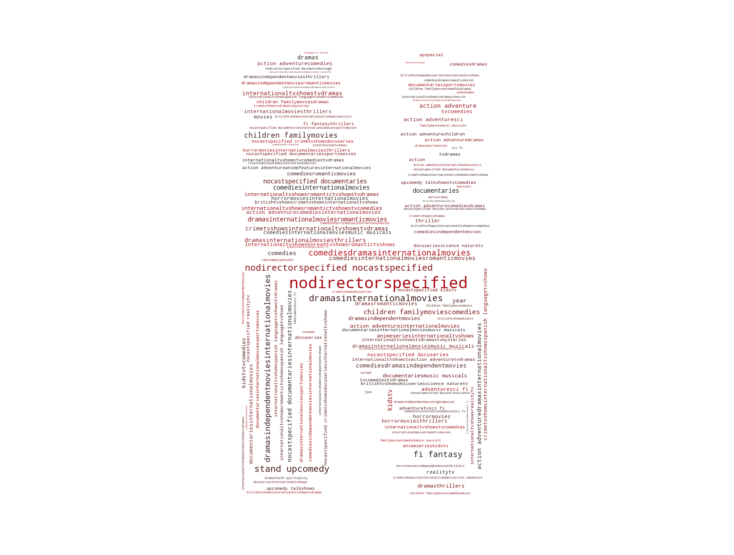

In [94]:
# Visualization of 'metadata_soup' column for better understanding using WordCloud
word_map('metadata_soup')

Next step, we will be fitting our metadata_soup in **TfidfVectorizer** to create the matrix and with the help of **linear_kernel**, we will find the cosine_similarity just like in the plot-based recommender.

In [95]:
# Fiting our data in TfidfVectorizer
tfidf = TfidfVectorizer(stop_words = 'english')
multi_matrix = tfidf.fit_transform(filters['metadata_soup'])

In [96]:
# Shape of multi_matrix
print('-'*50)
print('\033[1m','Shape of the multi_matrix dataset: {}'. format(multi_matrix.shape), '\033[0m')
print('-'*50)

--------------------------------------------------
 Shape of the multi_matrix dataset: (8807, 66746) 
--------------------------------------------------


In [97]:
# Computing the Cosine Similarity matrix based on the count_matrix
multi_sim = linear_kernel(multi_matrix, multi_matrix)

Using the title column again, we will create our index

In [98]:
# Reset index of our main DataFrame and construct reverse mapping as before
filters=filters.reset_index()
fill_indices = pd.Series(filters.index, index=filters['title'])

Lastly, we will be creating our recommender by defining a function, **multi_recommend**, to do our task of finding the ten most similar content based on the input **Title**.

In [99]:
def multi_recommend(title, multi_sim = multi_sim):
    
    title = title.replace(' ','').lower()
    ids = fill_indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(multi_sim[ids]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]         # Starting with 1 as 0 is the title itself

    # Get the movie indices
    content_index = [i[0] for i in sim_scores]
    
    # Features to be shown
    features=['title', 'director','cast', 'genre', 'rating', 'duration', 'description']
    # Return the top 10 most similar movies
    return rec[features].iloc[content_index].reset_index(drop = True)

In [100]:
# Running the function
multi_recommend('NCIS')

title               director  \
0                                       Secret City  No Director Specified   
1                                       The Keepers  No Director Specified   
2                                Tiny Pretty Things  No Director Specified   
3                                           Dynasty  No Director Specified   
4  This Is a Robbery: The World's Biggest Art Heist  No Director Specified   
5                                     The Staircase  No Director Specified   
6                                        The Sinner  No Director Specified   
7                                        MINDHUNTER  No Director Specified   
8                                 A Christmas Catch  No Director Specified   
9                                           Yes Man            Peyton Reed   

                                                cast  \
0  Anna Torv, Jacki Weaver, Dan Wyllie, Alex Dimi...   
1                                  No Cast Specified   
2  Lauren Holly, Kylie Jefferson, Casimere Jollet...   
3  Elizabeth Gillies, Nathalie Kelley, Grant Show...   
4                                  No Cast Specified   
5                                  No Cast Specified   
6  Jessica Biel, Bill Pullman, Christopher Abbott...   
7  Jonathan Groff, Holt McCallany, Anna Torv, Cot...   
8  Emily Alatalo, Lauren Holly, Yanic Truesdale, ...   
9  Jim Carrey, Zooey Deschanel, Bradley Cooper, J...   

                                             genre rating  duration  \
0  International TV Shows, TV Dramas, TV Mysteries  TV-MA         2   
1         Crime TV Shows, Docuseries, TV Mysteries  TV-MA         1   
2            TV Dramas, TV Mysteries, TV Thrillers  TV-MA         1   
3                                        TV Dramas  TV-14         3   
4         Crime TV Shows, Docuseries, TV Mysteries  TV-MA         1   
5         Crime TV Shows, Docuseries, TV Mysteries  TV-MA         1   
6          Crime TV Shows, TV Dramas, TV Mysteries  TV-MA         3   
7          Crime TV Shows, TV Dramas, TV Mysteries  TV-MA         2   
8                          Dramas, Romantic Movies   TV-G        87   
9                        Comedies, Romantic Movies  PG-13       104   

                                         description  
0  A student's protest leads to a government scan...  
1  This docuseries examines the decades-old murde...  
2  When an attack brings down the star student at...  
3  The Carringtons and the Colbys feud for contro...  
4  In 1990, two men dressed as cops con their way...  
5  Accident or murder? After the mysterious death...  
6  When a young mother inexplicably stabs a stran...  
7  In the late 1970s two FBI agents expand crimin...  
8  A cop working undercover to trail a possible d...  
9  After a bitter divorce, a loan officer falls u...

We can see better results as compared to the previous recommender, giving us recommendations more similar to our input title.

## Testing the Recommender

In this section, we will test both recommenders using some examples to compare and find the difference between the outputs.

### Example 1: Movie 'Jodhaa Akbar'

**Synopsis**: The movie is about the love story between Jalaluddin Mohammad Akbar, the Mughal Emperor of Hindustan, and Rajput princess Jodhaa which sets in 16th-century India.

Let's see the results of the plot-based recommender.

In [101]:
# Plot based recommendor
des_recommend('Jodhaa Akbar')

title  \
0                                   Mahmut & Meryem   
1                                      Akbar Birbal   
2                           Know Your Enemy - Japan   
3                  Age of Samurai: Battle for Japan   
4                                        The Tudors   
5  The Memphis Belle: A Story of a\nFlying Fortress   
6                                           Shorgul   
7                             The Seven Deadly Sins   
8               Chhota Bheem and The ShiNobi Secret   
9                                    Kate & Leopold   

                        director  \
0          No Director Specified   
1          No Director Specified   
2       Frank Capra, Joris Ivens   
3          No Director Specified   
4          No Director Specified   
5                  William Wyler   
6  Jitendra Tiwari, Pranav Singh   
7          No Director Specified   
8                  Rajiv Chilaka   
9                  James Mangold   

                                                cast  \
0  Aras Bulut İynemli, Eva Dedova, Fahreddin Mana...   
1          Kiku Sharda, Vishal Kotian, Delnaaz Irani   
2                        Walter Huston, Dana Andrews   
3  Masayoshi Haneda, Masami Kosaka, Hideaki Ito, ...   
4  Jonathan Rhys Meyers, Henry Cavill, James Frai...   
5                                  No Cast Specified   
6  Ashutosh Rana, Jimmy Shergill, Suha Gezen, San...   
7  Yuki Kaji, Sora Amamiya, Misaki Kuno, Aoi Yuki...   
8  Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jig...   
9  Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...   

                                               genre rating  duration  \
0  International TV Shows, Romantic TV Shows, TV ...  TV-14         1   
1                   Kids' TV, TV Comedies, TV Dramas   TV-G         1   
2                      Classic Movies, Documentaries  TV-14        63   
3                 Docuseries, International TV Shows  TV-MA         1   
4                                          TV Dramas  TV-MA         4   
5                      Classic Movies, Documentaries  TV-PG        40   
6                       Dramas, International Movies  TV-14       122   
7               Anime Series, International TV Shows  TV-14         5   
8                           Children & Family Movies  TV-Y7        64   
9                          Comedies, Romantic Movies  PG-13       118   

                                         description  
0  In the 16th century, the heir to a Muslim empi...  
1  From battles of wit to fights for justice, Emp...  
2  Though culturally insensitive by modern standa...  
3  Dynamic reenactments and expert commentaries b...  
4  All the splendor and scandal of England's 16th...  
5  This documentary centers on the crew of the B-...  
6  A Hindu boy's feelings for a Muslim girl expos...  
7  When a kingdom is taken over by tyrants, the d...  
8  After learning of a samurai village under thre...  
9  A present-day woman takes responsibility for g...

The overall similarity between the contents suggested by the recommender is not so high. Some suggestions are even TV shows and animated series just having a medieval/historical setting in their stories.

Let's check the results of our multi-matrix recommender.

In [102]:
# Multiple matrix/features recommendor
multi_recommend('Jodhaa Akbar')

title               director  \
0  Panipat - The Great Betrayal     Ashutosh Gowariker   
1                  Mohenjo Daro     Ashutosh Gowariker   
2          Ram Teri Ganga Maili             Raj Kapoor   
3                        Lagaan     Ashutosh Gowariker   
4                     Guzaarish  Sanjay Leela Bhansali   
5                Happy New Year             Farah Khan   
6                Ishqedarriyaan          V. K. Prakash   
7                  Kung Fu Yoga           Stanley Tong   
8                         Pukar      Rajkumar Santoshi   
9                      Brothers         Karan Malhotra   

                                                cast  \
0  Sanjay Dutt, Arjun Kapoor, Kriti Sanon, Zeenat...   
1  Hrithik Roshan, Sonakshi Sinha, Pooja Hegde, K...   
2  Mandakini, Rajiv Kapoor, Divya Rana, Saeed Jaf...   
3  Aamir Khan, Gracy Singh, Rachel Shelley, Paul ...   
4  Hrithik Roshan, Aishwarya Rai Bachchan, Sherna...   
5  Shah Rukh Khan, Deepika Padukone, Abhishek Bac...   
6          Suhasini Mulay, Kavin Dave, Evelyn Sharma   
7  Jackie Chan, Disha Patani, Amyra Dastur, Sonu ...   
8  Anil Kapoor, Madhuri Dixit, Namrata Shirodkar,...   
9  Akshay Kumar, Sidharth Malhotra, Jackie Shroff...   

                                               genre rating  duration  \
0      Dramas, International Movies, Romantic Movies  TV-14       171   
1   Action & Adventure, Dramas, International Movies  TV-14       168   
2       Classic Movies, Dramas, International Movies  TV-14       178   
3     Dramas, International Movies, Music & Musicals     PG       224   
4                       Dramas, International Movies  TV-14       121   
5               Action & Adventure, Comedies, Dramas  TV-14       179   
6      Dramas, International Movies, Romantic Movies  TV-14       130   
7  Action & Adventure, Comedies, International Mo...  TV-PG       107   
8   Action & Adventure, Dramas, International Movies  TV-14       165   
9   Action & Adventure, Dramas, International Movies  TV-14       155   

                                         description  
0  In 18th-century India, a Maratha commander lea...  
1  A courageous villager moves to the ancient cit...  
2  Abandoned by her new husband and father of her...  
3  In 1890s India, an arrogant British commander ...  
4  After an onstage disaster leaves an illusionis...  
5  A revenge-seeking diamond thief gathers a ragt...  
6  A young millionaire is willing to do anything ...  
7  Two mismatched archaeologists battle a team of...  
8  A notorious terrorist manipulates an Indian ar...  
9  After a troubled past with their alcoholic fat...

The suggestions given by our recommender are much more similar to our example. Most of them are Bollywood movies, having a setting related to history or medieval times and having the **'Dramas'** genre common between them.

### Example 2: TV Show 'Supernatural'

**Synopsis**: The show follows brothers Sam and Dean Winchester, who travel across America in a black 1967 Chevy Impala, investigating and combating supernatural events and other unexplained occurrences.

Let's see the results of both recommenders.

In [103]:
des_recommend('Supernatural')

title                    director  \
0                               Boomika         Rathindran R Prasad   
1                       Boomika (Hindi)         Rathindran R Prasad   
2                   Boomika (Malayalam)         Rathindran R Prasad   
3                      Boomika (Telugu)         Rathindran R Prasad   
4                       Angel 'N' Devil       No Director Specified   
5                              Outlawed  Adam Collins, Luke Radford   
6                         Haunted House       No Director Specified   
7  Monster Hunter: Legends of the Guild             Steven Yamamoto   
8    The Witcher: Nightmare of the Wolf                Han Kwang Il   
9                       Out of Thin Air                Dylan Howitt   

                                                cast  \
0  Aishwarya Rajesh, Vidhu, Surya Ganapathy, Madh...   
1  Aishwarya Rajesh, Vidhu, Surya Ganapathy, Madh...   
2  Aishwarya Rajesh, Vidhu, Surya Ganapathy, Madh...   
3  Aishwarya Rajesh, Vidhu, Surya Ganapathy, Madh...   
4  Simon Lian, Teddy Chen, Sylvia Wang, Cosmos Li...   
5  Adam Collins, Jessica Norris, Ian Hitchens, St...   
6  Jo Hyun-jung, Gim Young-eun, Gim Chae-ha, I So...   
7  Ben Rausch, Erica Lindbeck, Dante Basco, Brand...   
8  Theo James, Mary McDonnell, Lara Pulver, Graha...   
9                                  No Cast Specified   

                                               genre rating  duration  \
0     Horror Movies, International Movies, Thrillers  TV-14       122   
1     Horror Movies, International Movies, Thrillers  TV-14       122   
2     Horror Movies, International Movies, Thrillers  TV-14       122   
3     Horror Movies, International Movies, Thrillers  TV-14       122   
4  International TV Shows, TV Action & Adventure,...  TV-14         1   
5                                 Action & Adventure  TV-MA       102   
6                          Kids' TV, Korean TV Shows   TV-G         1   
7  Action & Adventure, Anime Features, Children &...  TV-PG        59   
8                 Action & Adventure, Anime Features  TV-MA        84   
9                Documentaries, International Movies  TV-MA        85   

                                         description  
0  Paranormal activity at a lush, abandoned prope...  
1  Paranormal activity at a lush, abandoned prope...  
2  Paranormal activity at a lush, abandoned prope...  
3  Paranormal activity at a lush, abandoned prope...  
4  In a world known as the Copper Dimension, a gr...  
5  After a failed mission, an ex-Royal Marines Co...  
6  With help from a 102-year-old goblin dwelling ...  
7  In a world where humans and fearsome monsters ...  
8  Escaping from poverty to become a witcher, Ves...  
9  Picking up 40 years after six were convicted f...

In [104]:
multi_recommend('Supernatural')

title               director  \
0                  From Dusk Till Dawn  No Director Specified   
1  The Twilight Zone (Original Series)  No Director Specified   
2           Avatar: The Last Airbender  No Director Specified   
3                  Pee-wee's Playhouse  No Director Specified   
4                        Stargate SG-1  No Director Specified   
5                Star Trek: Enterprise  No Director Specified   
6                                Haven  No Director Specified   
7                              Frasier  No Director Specified   
8                              Friends  No Director Specified   
9               The Andy Griffith Show  No Director Specified   

                                                cast  \
0  D.J. Cotrona, Zane Holtz, Eiza Gonzalez, Jesse...   
1                                        Rod Serling   
2  Zach Tyler, Mae Whitman, Jack De Sena, Dee Bra...   
3                                       Paul Reubens   
4  Richard Dean Anderson, Michael Shanks, Amanda ...   
5  Scott Bakula, John Billingsley, Jolene Blalock...   
6  Emily Rose, Lucas Bryant, Nicholas Campbell, E...   
7  Kelsey Grammer, Jane Leeves, David Hyde Pierce...   
8  Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...   
9  Andy Griffith, Ron Howard, Don Knotts, Frances...   

                                               genre rating  duration  \
0  Classic & Cult TV, TV Action & Adventure, TV H...  TV-MA         3   
1             Classic & Cult TV, TV Sci-Fi & Fantasy  TV-14         4   
2  Classic & Cult TV, Kids' TV, TV Action & Adven...  TV-Y7         3   
3           Classic & Cult TV, Kids' TV, TV Comedies  TV-PG         5   
4  Classic & Cult TV, TV Action & Adventure, TV S...  TV-MA        10   
5  Classic & Cult TV, TV Action & Adventure, TV S...  TV-14         4   
6         Classic & Cult TV, TV Horror, TV Mysteries  TV-14         5   
7                     Classic & Cult TV, TV Comedies  TV-PG        11   
8                     Classic & Cult TV, TV Comedies  TV-14        10   
9                     Classic & Cult TV, TV Comedies   TV-G         8   

                                         description  
0  Bank-robbing brothers encounter vengeful lawme...  
1  Hosted by creator Rod Serling, this groundbrea...  
2  Siblings Katara and Sokka wake young Aang from...  
3  Pee-wee Herman brings his stage show to the ma...  
4  Stargate Command roars into action when Jack O...  
5  Capt. Archer and his crew explore space and di...  
6  Residents of Haven, Maine, are plagued by supe...  
7  Frasier Crane is a snooty but lovable Seattle ...  
8  This hit sitcom follows the merry misadventure...  
9  Homespun humor and easygoing Sheriff Andy Tayl...

The suggestions of the plot-based recommender are based on the plot, therefore, we can see almost all the suggestions are somewhat related to fighting paranormal activity. Suggestions are good, but not all are accurate.

Whereas, all suggested contents by multi-matrix recommender have the **'Classic & Cult TV'** genre in common. We can see that all the contents are set up in the same way as our example, which gives us the impression that it's working.

# Conclusions:

## Case Study:

* The total amount of content available on the platform is more of a movie type. It varies from country to country, but the majority do prefer movies to TV shows.


* More than 90% of the content available in India on Netflix is of movie type. Netflix India does have done their research while adding content, but the trend of watching TV series is increasing.


* Most content is targeted towards Mature/Adults and Teenagers based on the ratings (TV-MA and TV-14).


* The average duration of the movies added of the 2000s and after is 125 mins(2.08hrs).


* More than half of the TV series on the platform has only 1 season.


* Movies comprise 20 types of genre categories whereas, TV Shows comprise 22 types of genre categories.


* International Movies/TV Shows are the most common genre in all the content, followed by Dramas/TV Dramas and Comedies/TV Comedies.


* Around 46% of the content is targeted toward Adults. This percentage does change from country to country based on the target audience to that Netflix is providing its service.


* There is no particular celeb or director whose content is more than others on the platform. Some have more content than other, but not enough to dominate the market of their respective regions.

## Recommendation System:

* A plot-based recommendation system may work fine if it were the only important feature present in our dataset, although cast, director, and genre also play an important role in creating a good recommendation system.


* While country, rating, release year, and other features present in the dataset are significant, they are not essential in creating a content-based recommendation system. If they are included, the system will generate incorrect suggestions and will be meaningless.